In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from statistics import mode
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import datetime as dt
import timeit
import calendar
import time as timer_time
global_begin = timer_time.time()
%matplotlib inline

In [2]:
df_original = pd.read_csv('card_transactions.csv', 
                          converters={'Merchnum': lambda x: str(x)})

In [3]:
df_original['Merch description'] = df_original['Merch description'].str.upper()


In [4]:
df_original.dtypes

Recnum                 int64
Cardnum                int64
Date                  object
Merchnum              object
Merch description     object
Merch state           object
Merch zip            float64
Transtype             object
Amount               float64
Fraud                  int64
dtype: object

## Keep only P Transtype
Remove all records that do not have a value of "P" in the Transtype data field.

In [5]:
df = df_original.loc[df_original['Transtype'] == 'P']
print(len(df))
df.head()

96398


Recnum     Cardnum        Date       Merchnum        Merch description Merch state  Merch zip Transtype  Amount  Fraud
0       1  5142190439  2006-01-01  5509006296254   FEDEX SHP 12/23/09 AB#          TN    38118.0         P    3.62      0
1       2  5142183973  2006-01-01    61003026333  SERVICE MERCHANDISE #81          MA     1803.0         P   31.42      0
2       3  5142131721  2006-01-01  4503082993600        OFFICE DEPOT #191          MD    20706.0         P  178.49      0
3       4  5142148452  2006-01-01  5509006296254   FEDEX SHP 12/28/09 AB#          TN    38118.0         P    3.62      0
4       5  5142190439  2006-01-01  5509006296254   FEDEX SHP 12/23/09 AB#          TN    38118.0         P    3.62      0

In [6]:
df['Amount'].idxmax()

52714

In [7]:
df=df.drop(52714,axis=0)

### Mech State imputation

In [8]:
missing_state = np.where(pd.isnull(df['Merch state']))[0]
len(missing_state)

1020

In [9]:
#### These lines of code enable us to use data fields with NaN values when using groupby ####
# Get rid of the records with NaN values in the Merch zip data field
zip_temp = df.loc[df['Merch zip'].notnull(), ['Merch zip', 'Merch state']]


In [10]:
# Groupby zip, then find the mode of the state
zip_temp_state = zip_temp.groupby(['Merch zip'])['Merch state'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
zip_temp_state


0        TN
1        MA
2        MD
3        TN
4        TN
         ..
96748    KY
96749    OH
96750    OH
96751    CA
96752    NJ
Name: Merch state, Length: 92097, dtype: object

In [11]:
# Make a dictionary to match the Recnum to the mode of the zip from the groupby done above
zip_temp_state_dict = pd.Series(zip_temp_state.values,index=zip_temp_state.index+1).to_dict()

In [12]:
# Map the dictionary back to the "Merch state" data field
df.loc[df['Merch state'].isnull(),
       'Merch state'] = df['Recnum'].map(zip_temp_state_dict)

In [13]:
len(np.where(pd.isnull(df['Merch state']))[0])

1000

In [14]:
df[df['Merch state'].isna()]

Recnum     Cardnum        Date Merchnum         Merch description Merch state  Merch zip Transtype  Amount  Fraud
262       263  5142257575  2006-01-04            RETAIL DEBIT ADJUSTMENT         NaN        NaN         P  320.00      0
272       273  5142124791  2006-01-04            RETAIL DEBIT ADJUSTMENT         NaN        NaN         P  970.00      0
400       401  5142276099  2006-01-04            RETAIL DEBIT ADJUSTMENT         NaN        NaN         P   82.59      0
476       477  5142267793  2006-01-05            RETAIL DEBIT ADJUSTMENT         NaN        NaN         P   17.59      0
487       488  5142267793  2006-01-05           RETAIL CREDIT ADJUSTMENT         NaN        NaN         P   19.69      0
...       ...         ...         ...      ...                       ...         ...        ...       ...     ...    ...
96360   96361  5142225264  2006-12-29           RETAIL CREDIT ADJUSTMENT         NaN        NaN         P  317.80      0
96563   96564  5142211003  2006-12-30            RETAIL DEBIT ADJUSTMENT         NaN        NaN         P  168.00      0
96603   96604  5142182645  2006-12-30           RETAIL CREDIT ADJUSTMENT         NaN        NaN         P  229.25      0
96651   96652  5142151962  2006-12-30            RETAIL DEBIT ADJUSTMENT         NaN        NaN         P  125.00      0
96730   96731  5142122644  2006-12-31            RETAIL DEBIT ADJUSTMENT         NaN        NaN         P  340.79      0

[1000 rows x 10 columns]

In [15]:
merchtemp=df.groupby('Merchnum')['Merch state'].transform(lambda x: 
                                                          x.fillna(x.mode(dropna=True)[0] if not x.mode(dropna=True).empty else np.nan))

In [16]:
merchtemp_dict = pd.Series(merchtemp.values,
                           index=merchtemp.index+1).to_dict()

In [17]:
df.loc[df['Merch state'].isnull(),
       'Merch state'] = df['Recnum'].map(merchtemp_dict)

In [18]:
len(np.where(pd.isnull(df['Merch state']))[0])

90

In [19]:
del merchtemp, merchtemp_dict,zip_temp,zip_temp_state,zip_temp_state_dict

In [20]:
df['Merch state']=df['Merch state'].fillna(1)

In [21]:
for i in df.index:
    if df.loc[i,'Merch state']==1:
        if (df.loc[i,'Merch zip'] in range(600,800) or df.loc[i,'Merch zip'] in range(900,1000)):
            df.loc[i,'Merch state'] = 'PR'

In [22]:
len(df[df['Merch state']==1])

50

In [23]:
df['Merch state']=df['Merch state'].replace(1,np.nan)

In [24]:
df['Merch state'].fillna('Unk',inplace=True)

### Merch Num imputation

In [25]:
### replace 0 with NaN

In [26]:
df['Merchnum']=np.where(df['Merchnum']=='0', np.nan,df['Merchnum'])

In [27]:
len(df[df['Merchnum'].isna()])

53

In [28]:
#Fill in with mode of merch description

In [29]:
mnum=df.groupby('Merch description')['Merchnum'].transform(lambda x: x.fillna(x.mode(dropna=True)[0] \
                                                                        if not x.mode(dropna=True).empty else np.nan))

In [30]:
mnum_dict = pd.Series(mnum.values,index=mnum.index+1).to_dict()

In [31]:
df.loc[df['Merchnum'].isnull(),'Merchnum'] = df['Recnum'].map(mnum_dict)

In [32]:
len(df[df['Merchnum'].isna()])

37

In [33]:
#Fill remaining missing values with the Recnum to avoid linkages

In [34]:
df['Merchnum'].fillna('Unk',inplace=True)

In [35]:
len(df[df['Merchnum'].isna()])

0

### Impute Merch zip

In [36]:
len(df[df['Merch zip'].isna()])

4300

In [37]:
zip_temp=df.groupby('Merchnum')['Merch zip'].transform(lambda x: x.fillna(x.mode(dropna=True)[0] \
                                                                        if not x.mode(dropna=True).empty else np.nan))

In [38]:
zip_temp_dict = pd.Series(zip_temp.values,
                          index=zip_temp.index+1).to_dict()

In [39]:
df.loc[df['Merch zip'].isnull(),
       'Merch zip'] = df['Recnum'].map(zip_temp_dict)

In [40]:
len(df[df['Merch zip'].isna()])

1089

In [41]:
df[df['Merch zip'].isna()]

Recnum     Cardnum        Date       Merchnum       Merch description Merch state  Merch zip Transtype  Amount  Fraud
51         52  5142204384  2006-01-02  5000006000095  IBM INTERNET  01000025          NY        NaN         P   20.15      0
54         55  5142146340  2006-01-02  5000006000095  IBM INTERNET  01000025          NY        NaN         P   23.90      0
55         56  5142260984  2006-01-02  5000006000095  IBM INTERNET  01000025          NY        NaN         P   19.95      0
58         59  5142204384  2006-01-02  5000006000095  IBM INTERNET  01000025          NY        NaN         P   20.15      0
59         60  5142204384  2006-01-02  5000006000095  IBM INTERNET  01000025          NY        NaN         P   20.15      0
...       ...         ...         ...            ...                     ...         ...        ...       ...     ...    ...
96242   96243  5142248067  2006-12-29   991900855333      STARFLEET COURIERS          TX        NaN         P  126.50      0
96274   96275  5142248067  2006-12-29   991900855333      STARFLEET COURIERS          TX        NaN         P   83.50      0
96545   96546  5142227183  2006-12-30  9900020008506   UNICOR FED PRISON IND          KY        NaN         P  395.00      0
96668   96669  5142195081  2006-12-30   465905123335   DURHAM SAFE & LOCK CO          NC        NaN         P  103.00      0
96734   96735  5142166343  2006-12-31   990903450339         OKEECHOBEE NEWS          FL        NaN         P   33.17      0

[1089 rows x 10 columns]

In [42]:
zip_1=df.groupby('Merch state')['Merch zip'].transform(lambda x: x.mode(dropna=True)[0]\
                                                 if not x.mode(dropna=True).empty else np.nan)

In [43]:
zip_1_dict = pd.Series(zip_1.values,index=zip_1.index+1).to_dict()

In [44]:
df.loc[df['Merch zip'].isnull(),'Merch zip'] = df['Recnum'].map(zip_1_dict)

In [45]:
len(df[df['Merch zip'].isna()])

0

In [46]:
df.isnull().sum()/len(df)*100

Recnum               0.0
Cardnum              0.0
Date                 0.0
Merchnum             0.0
Merch description    0.0
Merch state          0.0
Merch zip            0.0
Transtype            0.0
Amount               0.0
Fraud                0.0
dtype: float64

In [47]:
df['Merch zip'] = np.where(df['Merch description']=='RETAIL CREDIT ADJUSTMENT','unknown',df['Merch zip'])
df['Merch zip'] = np.where(df['Merch description']=='RETAIL DEBIT ADJUSTMENT','unknown',df['Merch zip'])
df['Merch state'] = np.where(df['Merch description']=='RETAIL CREDIT ADJUSTMENT','unknown',df['Merch state'])
df['Merch state'] = np.where(df['Merch description']=='RETAIL CREDIT ADJUSTMENT','unknown',df['Merch state'])

In [48]:
# All NaN values have been removed and dataframe has been cleaned

In [49]:
df.to_csv('df_imputed.csv')

In [50]:
df.dtypes

Recnum                 int64
Cardnum                int64
Date                  object
Merchnum              object
Merch description     object
Merch state           object
Merch zip             object
Transtype             object
Amount               float64
Fraud                  int64
dtype: object

In [51]:
df_var=deepcopy(df)

In [52]:
### Convert variables to different types

In [53]:
# df_cleaned['Cardnum']=df_cleaned['Cardnum'].astype(int)
# df_cleaned['Date']=pd.to_datetime(df_cleaned['Date'])

# Variable Creation

## Create the Categorical Candidate Variables

In [54]:
df_var['Date']=pd.to_datetime(df_var['Date'])

In [55]:
df_var.dtypes

Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                    object
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

In [56]:
### Convert card number to string to enable linkage
df_var['Cardnum']=df_var['Cardnum'].astype(str)

In [57]:
df_var['card-merch'] = df_var['Cardnum'] + df_var['Merchnum'] 
df_var['card-zip'] = df_var['Cardnum'] + df_var['Merch zip']
df_var['card-state'] = df_var['Cardnum'] + df_var['Merch state']
df_var['merchnum-merchstate'] = df_var['Merchnum'] + df_var['Merch state']
df_var['merchnum-zip'] = df_var['Merchnum'] + df_var['Merch zip']

In [58]:
# Code to convert fields back to INT if needed
#cols_int = ['Recnum','Cardnum','Merchnum','Merch zip']
# cols_var = df_var.columns

# for item in cols_var:
#     temp = set(item.split('-'))
# #     print(temp)
#     if temp.issubset(cols_int):
#         try:
#             df_var[item] = df_var[item].astype(int)
#         except:
#             try:
#                 df_var[item] = df_var[item].astype('int64')
#             except:
#                 print('The values are probably too big:', item)
#                 continue

In [59]:
df_var.dtypes

Recnum                          int64
Cardnum                        object
Date                   datetime64[ns]
Merchnum                       object
Merch description              object
Merch state                    object
Merch zip                      object
Transtype                      object
Amount                        float64
Fraud                           int64
card-merch                     object
card-zip                       object
card-state                     object
merchnum-merchstate            object
merchnum-zip                   object
dtype: object

## Days-Since Variables

In [60]:
def daysincecalculator(df:pd.DataFrame, g1: list, g2: str, name: str) -> pd.DataFrame :
    day_since = df.groupby(g1)[g1].first()
    day_since = day_since.rename_axis(['None' for i in range(len(g1))]).groupby(g2).diff()
    day_since.columns = [name]
    day_since = day_since.rename_axis(g1)
    day_since[name] = day_since[name].dt.days.fillna(0)
    day_since = day_since.reset_index()
    return day_since

In [61]:
ds=df_var.groupby(['Cardnum','Date'])['Cardnum','Date'].first()

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/910245886.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ds=df_var.groupby(['Cardnum','Date'])['Cardnum','Date'].first()


In [62]:
ds

Cardnum       Date
Cardnum    Date                             
5142110002 2006-10-12  5142110002 2006-10-12
5142110081 2006-03-08  5142110081 2006-03-08
           2006-11-26  5142110081 2006-11-26
           2006-12-27  5142110081 2006-12-27
5142110313 2006-10-07  5142110313 2006-10-07
...                           ...        ...
5142847398 2006-03-21  5142847398 2006-03-21
           2006-03-22  5142847398 2006-03-22
           2006-03-24  5142847398 2006-03-24
           2006-03-28  5142847398 2006-03-28
           2006-03-29  5142847398 2006-03-29

[61905 rows x 2 columns]

In [63]:
ds.rename_axis(['None' for i in range(len(['Cardnum','Date']))])

Cardnum       Date
None       None                             
5142110002 2006-10-12  5142110002 2006-10-12
5142110081 2006-03-08  5142110081 2006-03-08
           2006-11-26  5142110081 2006-11-26
           2006-12-27  5142110081 2006-12-27
5142110313 2006-10-07  5142110313 2006-10-07
...                           ...        ...
5142847398 2006-03-21  5142847398 2006-03-21
           2006-03-22  5142847398 2006-03-22
           2006-03-24  5142847398 2006-03-24
           2006-03-28  5142847398 2006-03-28
           2006-03-29  5142847398 2006-03-29

[61905 rows x 2 columns]

In [64]:
time_ds_all=pd.datetime.now()
# Calculate the Days Since variables for the required columns
ds_cols = ['Cardnum','Merchnum','card-merch','card-state','card-zip','merchnum-merchstate','merchnum-zip']

ds_dict={}
for col in ds_cols:
    curr_time=pd.datetime.now()
    curr_name = 'daysSince_' + col #name of the current variable being created
    
    # Calculate the days-since variable (ds) and assign it to a global variable (curr_name)
    globals()[curr_name] = daysincecalculator(df_var, [col, 'Date'], col, col+'_daysSince')
    ds_dict[curr_name] = globals()[curr_name] # Save results to a dictionary
    print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
print("DONE!", pd.datetime.now()-time_ds_all)

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  time_ds_all=pd.datetime.now()
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  curr_time=pd.datetime.now()
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version.

Done with: Cardnum ; Time: 0:00:00.382149


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  curr_time=pd.datetime.now()


Done with: Merchnum ; Time: 0:00:02.368284


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  curr_time=pd.datetime.now()


Done with: card-merch ; Time: 0:00:07.063131


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  curr_time=pd.datetime.now()


Done with: card-state ; Time: 0:00:02.671692


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  curr_time=pd.datetime.now()


Done with: card-zip ; Time: 0:00:05.998565


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  curr_time=pd.datetime.now()


Done with: merchnum-merchstate ; Time: 0:00:02.361613
Done with: merchnum-zip ; Time: 0:00:02.394987
DONE! 0:00:23.241092


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print("Done with:", col, "; Time:", pd.datetime.now()-curr_time)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1900917855.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print("DONE!", pd.datetime.now()-time_ds_all)


In [65]:
ds_dict['daysSince_Cardnum']

Cardnum       Date  Cardnum_daysSince
0      5142110002 2006-10-12                0.0
1      5142110081 2006-03-08                0.0
2      5142110081 2006-11-26              263.0
3      5142110081 2006-12-27               31.0
4      5142110313 2006-10-07                0.0
...           ...        ...                ...
61900  5142847398 2006-03-21                3.0
61901  5142847398 2006-03-22                1.0
61902  5142847398 2006-03-24                2.0
61903  5142847398 2006-03-28                4.0
61904  5142847398 2006-03-29                1.0

[61905 rows x 3 columns]

In [66]:
#ds_dict is a dictionary of dataframes. 
#The values of the dictionary are dataframes and the keys are shown below.
ds_dict.keys()

dict_keys(['daysSince_Cardnum', 'daysSince_Merchnum', 'daysSince_card-merch', 'daysSince_card-state', 'daysSince_card-zip', 'daysSince_merchnum-merchstate', 'daysSince_merchnum-zip'])

In [67]:
df_temp = df_var.copy()

In [68]:
for i in ds_dict.keys():
    col_variable = i.split('_')[1]
    df_temp = pd.merge(df_temp,ds_dict[i], how = 'left',
                       on = [col_variable,'Date'])

In [69]:
df_temp

Recnum     Cardnum       Date       Merchnum        Merch description Merch state Merch zip Transtype   Amount  Fraud               card-merch           card-zip    card-state merchnum-merchstate          merchnum-zip  Cardnum_daysSince  Merchnum_daysSince  card-merch_daysSince  card-state_daysSince  card-zip_daysSince  merchnum-merchstate_daysSince  merchnum-zip_daysSince
0           1  5142190439 2006-01-01  5509006296254   FEDEX SHP 12/23/09 AB#          TN   38118.0         P     3.62      0  51421904395509006296254  514219043938118.0  5142190439TN     5509006296254TN  550900629625438118.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0
1           2  5142183973 2006-01-01    61003026333  SERVICE MERCHANDISE #81          MA    1803.0         P    31.42      0    514218397361003026333   51421839731803.0  5142183973MA       61003026333MA     610030263331803.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0
2           3  5142131721 2006-01-01  4503082993600        OFFICE DEPOT #191          MD   20706.0         P   178.49      0  51421317214503082993600  514213172120706.0  5142131721MD     4503082993600MD  450308299360020706.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0
3           4  5142148452 2006-01-01  5509006296254   FEDEX SHP 12/28/09 AB#          TN   38118.0         P     3.62      0  51421484525509006296254  514214845238118.0  5142148452TN     5509006296254TN  550900629625438118.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0
4           5  5142190439 2006-01-01  5509006296254   FEDEX SHP 12/23/09 AB#          TN   38118.0         P     3.62      0  51421904395509006296254  514219043938118.0  5142190439TN     5509006296254TN  550900629625438118.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0
...       ...         ...        ...            ...                      ...         ...       ...       ...      ...    ...                      ...                ...           ...                 ...                   ...                ...                 ...                   ...                   ...                 ...                            ...                     ...
96392   96749  5142276053 2006-12-31  3500000006160   BEST BUY      00001610          KY   41042.0         P    84.79      0  51422760533500000006160  514227605341042.0  5142276053KY     3500000006160KY  350000000616041042.0               37.0                 0.0                   0.0                  37.0                37.0                            0.0                     0.0
96393   96750  5142225701 2006-12-31  8090710030950   MARKUS OFFICE SUPPLIES          OH   45248.0         P   118.75      0  51422257018090710030950  514222570145248.0  5142225701OH     8090710030950OH  809071003095045248.0                2.0                 9.0                  11.0                   2.0                11.0                            9.0                     9.0
96394   96751  5142226486 2006-12-31  4503057341100            TECH PAC, INC          OH   45150.0         P   363.56      0  51422264864503057341100  514222648645150.0  5142226486OH     4503057341100OH  450305734110045150.0                1.0                 4.0                   0.0                   1.0                 0.0                            4.0                     4.0
96395   96752  5142244619 2006-12-31  8834000695412                  BUY.COM          CA   92656.0         P  2202.03      0  51422446198834000695412  514224461992656.0  5142244

In [70]:
df_var.shape

(96397, 15)

In [71]:
entities=df_var.columns[[1,3,5,6,10,11,12,13,14]]

In [72]:
df_var['check_date'] = df_var.Date
df_var['check_record'] = df_var.Recnum

In [73]:
## Frequency & Amount variables:   
start = timeit.default_timer()
for entity in entities:
    df_l = df_var[['Recnum', 'Date', entity]]
    df_r = df_var[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    for time in [0,1,3,7,14,30,60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        df_temp[col_name] = df_temp.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        df_temp[entity + '_actual/avg_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_avg_' + str(time)]
        df_temp[entity + '_actual/max_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_max_' + str(time)]
        df_temp[entity + '_actual/med_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_med_' + str(time)]
        df_temp[entity + '_actual/total_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/avg_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_avg_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/max_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_max_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2

Merchnum amount variables over past 7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


Merchnum_count_14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/25872570

Merchnum amount variables over past 14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


Merchnum_count_30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

Merchnum amount variables over past 30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


Merchnum_count_60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

Merchnum amount variables over past 60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

Merch state_count_0 ---> Done
Merch state amount variables over past 0 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

Merch state_count_1 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/avg_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_avg_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587

Merch state amount variables over past 1 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

Merch state_count_3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

Merch state amount variables over past 3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


Merch state_count_7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/25872570

Merch state amount variables over past 7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


Merch state_count_14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

Merch state amount variables over past 14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


Merch state_count_30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

Merch state amount variables over past 30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


Merch state_count_60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

Merch state amount variables over past 60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

Merch zip_count_0 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/total_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_total_' + str(time)]


Merch zip amount variables over past 0 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

Merch zip_count_1 ---> Done
Merch zip amount variables over past 1 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

Merch zip_count_3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/avg_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_avg_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/max_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_max_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2

Merch zip amount variables over past 3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

Merch zip_count_7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

Merch zip amount variables over past 7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


Merch zip_count_14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/25872570

Merch zip amount variables over past 14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


Merch zip_count_30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

Merch zip amount variables over past 30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


Merch zip_count_60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

Merch zip amount variables over past 60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

card-merch_count_0 ---> Done
card-merch amount variables over past 0 ---> Done
card-merch_count_1 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

card-merch amount variables over past 1 ---> Done
card-merch_count_3 ---> Done
card-merch amount variables over past 3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

card-merch_count_7 ---> Done
card-merch amount variables over past 7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

card-merch_count_14 ---> Done
card-merch amount variables over past 14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

card-merch_count_30 ---> Done
card-merch amount variables over past 30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

card-merch_count_60 ---> Done
card-merch amount variables over past 60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

card-zip_count_0 ---> Done
card-zip amount variables over past 0 ---> Done
card-zip_count_1 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

card-zip amount variables over past 1 ---> Done
card-zip_count_3 ---> Done
card-zip amount variables over past 3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/med_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_med_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/total_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_total_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_361

card-zip_count_7 ---> Done
card-zip amount variables over past 7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/max_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_max_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/med_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_med_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2

card-zip_count_14 ---> Done
card-zip amount variables over past 14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/avg_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_avg_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587

card-zip_count_30 ---> Done
card-zip amount variables over past 30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/25872570

card-zip_count_60 ---> Done
card-zip amount variables over past 60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

card-state_count_0 ---> Done
card-state amount variables over past 0 ---> Done
card-state_count_1 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/25872570

card-state amount variables over past 1 ---> Done
card-state_count_3 ---> Done
card-state amount variables over past 3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

card-state_count_7 ---> Done
card-state amount variables over past 7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

card-state_count_14 ---> Done
card-state amount variables over past 14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/25872570

card-state_count_30 ---> Done
card-state amount variables over past 30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

card-state_count_60 ---> Done
card-state amount variables over past 60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-merchstate_count_0 ---> Done
merchnum-merchstate amount variables over past 0 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-merchstate_count_1 ---> Done
merchnum-merchstate amount variables over past 1 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-merchstate_count_3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/med_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_med_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/total_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_total_' + str(time)]


merchnum-merchstate amount variables over past 3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-merchstate_count_7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

merchnum-merchstate amount variables over past 7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-merchstate_count_14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

merchnum-merchstate amount variables over past 14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


merchnum-merchstate_count_30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/25872570

merchnum-merchstate amount variables over past 30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


merchnum-merchstate_count_60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

merchnum-merchstate amount variables over past 60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-zip_count_0 ---> Done
merchnum-zip amount variables over past 0 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-zip_count_1 ---> Done
merchnum-zip amount variables over past 1 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-zip_count_3 ---> Done
merchnum-zip amount variables over past 3 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-zip_count_7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

merchnum-zip amount variables over past 7 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly frag

merchnum-zip_count_14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/258725

merchnum-zip amount variables over past 14 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


merchnum-zip_count_30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_med_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/25872570

merchnum-zip amount variables over past 30 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[col_name] = df_temp.Recnum.map(mapper2)


merchnum-zip_count_60 ---> Done


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_avg_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_max_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060

merchnum-zip amount variables over past 60 ---> Done
Total run time: 9.933713449299999mins


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_total_' + str(time)] = df_temp.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587257060.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[entity + '_actual/avg_' + str(time)] = df_temp['Amount'] / df_temp[entity + '_avg_' + str(time)]
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2587

In [74]:
df_temp.sample(5)

Recnum     Cardnum       Date       Merchnum       Merch description Merch state Merch zip Transtype  Amount  Fraud               card-merch           card-zip    card-state merchnum-merchstate          merchnum-zip  Cardnum_daysSince  Merchnum_daysSince  card-merch_daysSince  card-state_daysSince  card-zip_daysSince  merchnum-merchstate_daysSince  merchnum-zip_daysSince  Cardnum_count_0  Cardnum_avg_0  Cardnum_max_0  Cardnum_med_0  Cardnum_total_0  Cardnum_actual/avg_0  Cardnum_actual/max_0  Cardnum_actual/med_0  Cardnum_actual/total_0  Cardnum_count_1  Cardnum_avg_1  Cardnum_max_1  Cardnum_med_1  Cardnum_total_1  Cardnum_actual/avg_1  Cardnum_actual/max_1  Cardnum_actual/med_1  Cardnum_actual/total_1  Cardnum_count_3  Cardnum_avg_3  Cardnum_max_3  Cardnum_med_3  Cardnum_total_3  Cardnum_actual/avg_3  Cardnum_actual/max_3  Cardnum_actual/med_3  Cardnum_actual/total_3  Cardnum_count_7  Cardnum_avg_7  Cardnum_max_7  Cardnum_med_7  Cardnum_total_7  Cardnum_actual/avg_7  \
39207   39332  5142182433 2006-05-25  6880098906148         IWP NEWSLETTERS          VA   22202.0         P  990.00      0  51421824336880098906148  514218243322202.0  5142182433VA     6880098906148VA  688009890614822202.0                3.0                 6.0                   0.0                  13.0                 0.0                            6.0                     6.0                2       990.0000         990.00         990.00          1980.00              1.000000              1.000000                1.0000                0.500000                2     990.000000         990.00         990.00          1980.00              1.000000              1.000000              1.000000                0.500000                3     674.996667         990.00         990.00          2024.99              1.466674              1.000000              1.000000                0.488891                4     523.470000         990.00        529.445          2093.88              1.891226   
52604   52787  5142142792 2006-07-13  410810006NOT6     NEXT DAY OFFICE SUP          DC   20036.0         P  254.90      0  5142142792410810006NOT6  514214279220036.0  5142142792DC     410810006NOT6DC  410810006NOT620036.0                7.0                13.0                  27.0                  13.0                27.0                           13.0                    13.0                1       254.9000         254.90         254.90           254.90              1.000000              1.000000                1.0000                1.000000                1     254.900000         254.90         254.90           254.90              1.000000              1.000000              1.000000                1.000000                1     254.900000         254.90         254.90           254.90              1.000000              1.000000              1.000000                1.000000                2     131.070000         254.90        131.070           262.14              1.944762   
73842   74128  5142285759 2006-09-15  9900000036906  GSA/CUST SUPPLY CTR 91          VA   22150.0         P  140.78      0  51422857599900000036906  514228575922150.0  5142285759VA     9900000036906VA  990000003690622150.0                1.0                 1.0                   0.0                 137.0                 0.0                            1.0                     1.0                4       130.2275         343.23          81.64           520.91              1.081031              0.410162                1.7244                0.270258                5     297.180000         964.99         140.78          1485.90              0.473720              0.145888              1.000000                0.094744                6     250.475000         964.99          81.64          1502.85              0.562052              0.145888              1.724400                0.093675                6     250.475000         964.99         81.640          1502.85              0.562052   
21336   21374  5142125194 2006-03-23   

In [75]:
df_temp.columns.nunique()

589

In [76]:
start = timeit.default_timer()
# velocity change variables
for ent in entities:
    for d in ['0', '1','3']:
        for dd in ['7', '14', '30','60']:
            df_temp[ent + '_count_' + d + '_by_' + dd] =\
            df_temp[ent + '_count_' + d]/(df_temp[ent + '_count_' + dd])/float(dd)
            
print('run time: {}s'.format(timeit.default_timer() - start))


run time: 0.14434291700001722s


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1745540882.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[ent + '_count_' + d + '_by_' + dd] =\
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1745540882.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[ent + '_count_' + d + '_by_' + dd] =\
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1745540882.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

In [77]:
df_temp.columns.nunique()

697

In [78]:
#df_temp.to_csv('df_temp.csv')

In [79]:
data = deepcopy(df_temp)

In [80]:
### Risk table

In [81]:
#data= pd.read_csv('df_temp.csv', parse_dates =[3])

In [82]:
#data=data.drop('Unnamed: 0',axis=1)

In [83]:
#data.dtypes

In [84]:
data['Day_of_week']=data['Date'].dt.day_name()
#dt.date.strftime("%A")

In [85]:
data.sample(5)

Recnum     Cardnum       Date       Merchnum       Merch description Merch state Merch zip Transtype  Amount  Fraud               card-merch           card-zip    card-state merchnum-merchstate          merchnum-zip  Cardnum_daysSince  Merchnum_daysSince  card-merch_daysSince  card-state_daysSince  card-zip_daysSince  merchnum-merchstate_daysSince  merchnum-zip_daysSince  Cardnum_count_0  Cardnum_avg_0  Cardnum_max_0  Cardnum_med_0  Cardnum_total_0  Cardnum_actual/avg_0  Cardnum_actual/max_0  Cardnum_actual/med_0  Cardnum_actual/total_0  Cardnum_count_1  Cardnum_avg_1  Cardnum_max_1  Cardnum_med_1  Cardnum_total_1  Cardnum_actual/avg_1  Cardnum_actual/max_1  Cardnum_actual/med_1  Cardnum_actual/total_1  Cardnum_count_3  Cardnum_avg_3  Cardnum_max_3  Cardnum_med_3  Cardnum_total_3  Cardnum_actual/avg_3  Cardnum_actual/max_3  Cardnum_actual/med_3  Cardnum_actual/total_3  Cardnum_count_7  Cardnum_avg_7  Cardnum_max_7  Cardnum_med_7  Cardnum_total_7  Cardnum_actual/avg_7  \
46603   46756  5142216104 2006-06-21  9108242310006           STAPLES #8489          NC   28273.0         P  110.34      0  51422161049108242310006  514221610428273.0  5142216104NC     9108242310006NC  910824231000628273.0                1.0                 2.0                   2.0                   2.0                 2.0                            2.0                     2.0                1         110.34         110.34         110.34           110.34                   1.0                   1.0                   1.0                     1.0                2        117.135         123.93        117.135           234.27              0.941990              0.890341              0.941990                0.470995                4       215.2250         403.44        173.560           860.90              0.512673              0.273498              0.635746                0.128168               10     308.033000        1915.00        104.295          3080.33              0.358208   
1149     1154  5142192111 2006-01-07  6812500666737     HARSH INTERNATIONAL          CO   80615.0         P  399.08      0  51421921116812500666737  514219211180615.0  5142192111CO     6812500666737CO  681250066673780615.0                1.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1         399.08         399.08         399.08           399.08                   1.0                   1.0                   1.0                     1.0                2        239.860         399.08        239.860           479.72              1.663804              1.000000              1.663804                0.831902                4       170.7250         399.08        123.920           682.90              2.337560              1.000000              3.220465                0.584390                5     144.298000         399.08         80.640           721.49              2.765665   
59064   59265  5142142792 2006-08-03  5838000671607       DTI*DAYTIMERS INC          PA   18046.0         P   36.99      0  51421427925838000671607  514214279218046.0  5142142792PA     5838000671607PA  583800067160718046.0                1.0                 1.0                   0.0                   3.0                 0.0                            1.0                     1.0                1          36.99          36.99          36.99            36.99                   1.0                   1.0                   1.0                     1.0                2        442.110         847.23        442.110           884.22              0.083667              0.043660              0.083667                0.041833                4       563.5275        1221.95        497.585          2254.11              0.065640              0.030271              0.074339                0.016410                6     444.611667        1221.95        206.780          2667.67              0.083196   
46718   46871  5142280269 2006-06-21   

In [86]:
### Take out last two months of data before building risk table

In [87]:
mydata= data[data['Date'] < '2006-11-01']

In [88]:
mydata.groupby(['Day_of_week']).mean()

Recnum      Amount     Fraud  Cardnum_daysSince  Merchnum_daysSince  card-merch_daysSince  card-state_daysSince  card-zip_daysSince  merchnum-merchstate_daysSince  merchnum-zip_daysSince  Cardnum_count_0  Cardnum_avg_0  Cardnum_max_0  Cardnum_med_0  Cardnum_total_0  Cardnum_actual/avg_0  Cardnum_actual/max_0  Cardnum_actual/med_0  Cardnum_actual/total_0  Cardnum_count_1  Cardnum_avg_1  Cardnum_max_1  Cardnum_med_1  Cardnum_total_1  Cardnum_actual/avg_1  Cardnum_actual/max_1  Cardnum_actual/med_1  Cardnum_actual/total_1  Cardnum_count_3  Cardnum_avg_3  Cardnum_max_3  Cardnum_med_3  Cardnum_total_3  Cardnum_actual/avg_3  Cardnum_actual/max_3  Cardnum_actual/med_3  Cardnum_actual/total_3  Cardnum_count_7  Cardnum_avg_7  Cardnum_max_7  Cardnum_med_7  Cardnum_total_7  Cardnum_actual/avg_7  Cardnum_actual/max_7  Cardnum_actual/med_7  Cardnum_actual/total_7  Cardnum_count_14  Cardnum_avg_14  Cardnum_max_14  Cardnum_med_14  Cardnum_total_14  Cardnum_actual/avg_14  \
Day_of_week                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
Friday       41932.159962  456.996775  0.009788           5.238603           11.003687             16.663851             18.083870           18.019375                      11.148699               11.535465         1.945629     459.536168     608.005095     443.283694      1044.653048              0.999293              0.869339              1.252678                0.787730         2.903392     457.432335     770.480150     411.392356      1668.479781              1.020719              0.748549              1.902632                0.614728         4.448646     458.451775     948.222220     381.148834      2330.181329              1.045613              0.630018              2.852282                0.462173         6.233374     456.160138    1096.715368     354.672504      3024.274382              1.060116              0.551402              3.392444                0.369541         10.132274      452.456834     1319.395099      322.177829       4580.675554               1.083934   
Monday       45847.776792  387.478165  0.010095           6.408076           12.201387             16.188641             17.907617           18.211074                      12.266340               12.440298         2.591720     385.435629     473.989368     377.883475       776.226873              0.998625              0.884757              1.653561                0.771966         3.480371     385.628223     486.505487     376.439605       849.700743              1.003330              0.869503              1.769561                0.752347         4.792495     381.656352     647.369575     342.435771      1264.849950              0.982770              0.712899              2.140515                0.559629        10.103192     384.810540     930.045366     301.660767      2348.026478              0.979566              0.522639              3.127601                0.337836         15.081880      383.165769     1175.682650      270.393558       3745.226730               0.985731   
Saturday     38880.430186  346.298470  0.018626    

In [89]:
#count how many instances are there for each day of week
num_instances_day_of_week=mydata.groupby('Day_of_week').size()
num_instances_day_of_week

Day_of_week
Friday       14916
Monday        9807
Saturday      7785
Sunday        3193
Thursday     17118
Tuesday      14849
Wednesday    16302
dtype: int64

In [90]:
# Statistical Smoothing

In [91]:
c=4 
nmid=20 
fraud_rate_avg=mydata['Fraud'].mean()
fraud_rate_day_of_week=mydata.groupby('Day_of_week')['Fraud'].mean()

In [92]:
fraud_rate_day_of_week_smooth=fraud_rate_avg+(fraud_rate_day_of_week-fraud_rate_avg)/(1+np.exp(-(num_instances_day_of_week-nmid)/c))
fraud_rate_day_of_week_smooth

Day_of_week
Friday       0.009788
Monday       0.010095
Saturday     0.018626
Sunday       0.025994
Thursday     0.007127
Tuesday      0.009630
Wednesday    0.008711
dtype: float64

In [93]:
mydata['Day_of_week_smooth']=mydata['Day_of_week'].map(fraud_rate_day_of_week_smooth)

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/73141561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata['Day_of_week_smooth']=mydata['Day_of_week'].map(fraud_rate_day_of_week_smooth)


In [94]:
mydata.drop('Day_of_week',axis=1,inplace=True)

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/1491751033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata.drop('Day_of_week',axis=1,inplace=True)


In [95]:
mydata.rename(columns={'Day_of_week_smooth': 'Day_of_week'}, inplace=True)

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3790067826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata.rename(columns={'Day_of_week_smooth': 'Day_of_week'}, inplace=True)


In [96]:
data['dow_risk']=data.Day_of_week.map(fraud_rate_day_of_week_smooth)

In [97]:
data.drop('Day_of_week',axis=1,inplace=True)
#data.rename(columns={'Day_of_week_smooth': 'Day_of_week'}, inplace=True)

In [98]:
data

Recnum     Cardnum       Date       Merchnum        Merch description Merch state Merch zip Transtype   Amount  Fraud               card-merch           card-zip    card-state merchnum-merchstate          merchnum-zip  Cardnum_daysSince  Merchnum_daysSince  card-merch_daysSince  card-state_daysSince  card-zip_daysSince  merchnum-merchstate_daysSince  merchnum-zip_daysSince  Cardnum_count_0  Cardnum_avg_0  Cardnum_max_0  Cardnum_med_0  Cardnum_total_0  Cardnum_actual/avg_0  Cardnum_actual/max_0  Cardnum_actual/med_0  Cardnum_actual/total_0  Cardnum_count_1  Cardnum_avg_1  Cardnum_max_1  Cardnum_med_1  Cardnum_total_1  Cardnum_actual/avg_1  Cardnum_actual/max_1  Cardnum_actual/med_1  Cardnum_actual/total_1  Cardnum_count_3  Cardnum_avg_3  Cardnum_max_3  Cardnum_med_3  Cardnum_total_3  Cardnum_actual/avg_3  Cardnum_actual/max_3  Cardnum_actual/med_3  Cardnum_actual/total_3  Cardnum_count_7  Cardnum_avg_7  Cardnum_max_7  Cardnum_med_7  Cardnum_total_7  Cardnum_actual/avg_7  \
0           1  5142190439 2006-01-01  5509006296254   FEDEX SHP 12/23/09 AB#          TN   38118.0         P     3.62      0  51421904395509006296254  514219043938118.0  5142190439TN     5509006296254TN  550900629625438118.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1          3.620           3.62          3.620             3.62               1.00000              1.000000               1.00000                1.000000                1          3.620           3.62          3.620             3.62              1.000000              1.000000               1.00000                1.000000                1       3.620000           3.62           3.62             3.62              1.000000              1.000000              1.000000                1.000000                1       3.620000           3.62          3.620             3.62              1.000000   
1           2  5142183973 2006-01-01    61003026333  SERVICE MERCHANDISE #81          MA    1803.0         P    31.42      0    514218397361003026333   51421839731803.0  5142183973MA       61003026333MA     610030263331803.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1         31.420          31.42         31.420            31.42               1.00000              1.000000               1.00000                1.000000                1         31.420          31.42         31.420            31.42              1.000000              1.000000               1.00000                1.000000                1      31.420000          31.42          31.42            31.42              1.000000              1.000000              1.000000                1.000000                1      31.420000          31.42         31.420            31.42              1.000000   
2           3  5142131721 2006-01-01  4503082993600        OFFICE DEPOT #191          MD   20706.0         P   178.49      0  51421317214503082993600  514213172120706.0  5142131721MD     4503082993600MD  450308299360020706.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1        178.490         178.49        178.490           178.49               1.00000              1.000000               1.00000                1.000000                1        178.490         178.49        178.490           178.49              1.000000              1.000000               1.00000                1.000000                1     178.490000         178.49         178.49           178.49              1.000000              1.000000              1.000000                1.000000                1     178.490000         178.49        178.490           178.49              1.000000   
3           4  5142148452 2006-

In [99]:
fraud_rate_day_of_week

Day_of_week
Friday       0.009788
Monday       0.010095
Saturday     0.018626
Sunday       0.025994
Thursday     0.007127
Tuesday      0.009630
Wednesday    0.008711
Name: Fraud, dtype: float64

In [100]:
fraud_rate_day_of_week=fraud_rate_day_of_week.reset_index()
cats =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fraud_rate_day_of_week['Day_of_week']=pd.Categorical(fraud_rate_day_of_week['Day_of_week'],categories=cats,ordered=True)
fraud_rate_day_of_week=fraud_rate_day_of_week.sort_values('Day_of_week')
fraud_rate_day_of_week=fraud_rate_day_of_week.set_index('Day_of_week')

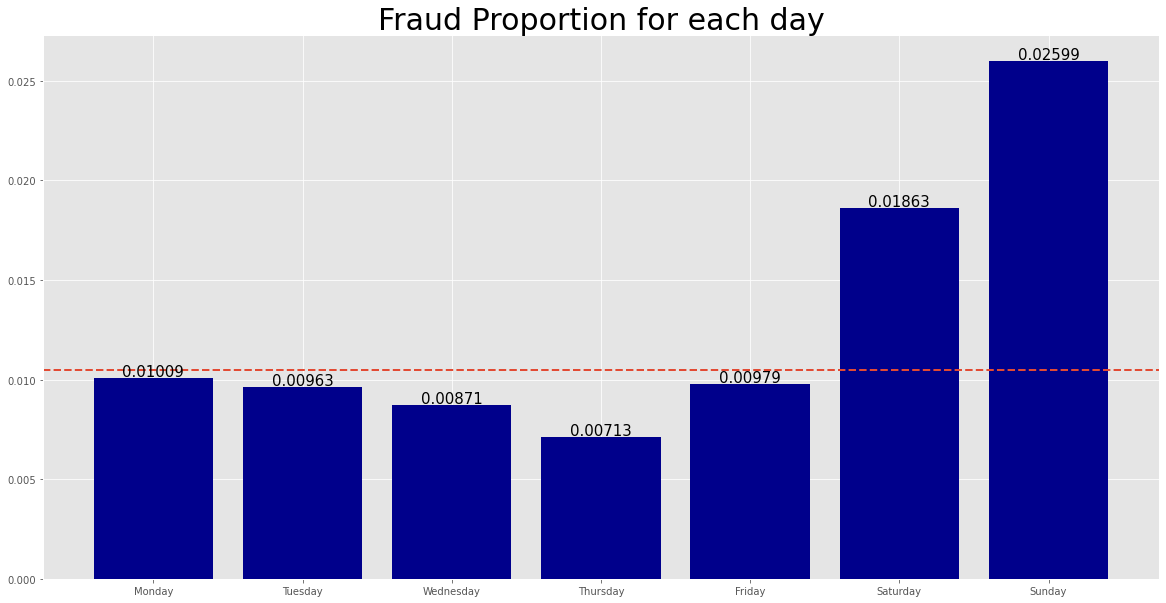

In [101]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(20,10))
plt.bar(data=fraud_rate_day_of_week,x=fraud_rate_day_of_week.index, height='Fraud',color='darkblue')
#ax.set_ylim(bottom=0.013)
ax.axhline(y=fraud_rate_avg,ls='--',lw=2)
for i, v in enumerate(fraud_rate_day_of_week.index):
    ax.text(v, fraud_rate_day_of_week.loc[v, 'Fraud'] + 0.0001, round(fraud_rate_day_of_week.loc[v, 'Fraud'], 5),horizontalalignment = 'center', fontsize = 15)

plt.title('Fraud Proportion for each day', fontsize = 30)
plt.show()

In [102]:
len(data.columns)

698

### Two Benford's Law variables

In [103]:
import re

In [104]:
cleaned_data = data[data['Merch description'].str.match(r'\b(?:fedex)\b',flags=re.IGNORECASE)==False].copy()
cleaned_data['Amount'] = cleaned_data['Amount'].astype(str)

In [105]:
def n_low(df):
    return ((df['Amount'].str.extract(r"([1-9])")=='1') | (df['Amount'].str.extract(r"([1-9])")=='2')).sum()

In [106]:
cardnums = cleaned_data.groupby('Cardnum').apply(n_low)
cardnums['n'] = cleaned_data.groupby('Cardnum')['Amount'].count()
cardnums['n_low'] = cleaned_data.groupby('Cardnum').apply(n_low)
cardnums = cardnums[['n', 'n_low']]
cardnums['n_high'] = cardnums['n'] - cardnums['n_low']

In [107]:
cardnums['n_low'] = cardnums['n_low'].replace(0,1)
cardnums['n_high'] = cardnums['n_high'].replace(0,1)

In [108]:
cardnums['R'] = 1.096 * cardnums['n_low'] / cardnums['n_high']
cardnums['1/R'] = 1 / cardnums['R']
cardnums['U'] = cardnums[['R', '1/R']].max(axis=1)

In [109]:
cardnums['t'] = (cardnums['n']-15)/3
cardnums['U*'] = 1 + ((cardnums['U']-1)/(1+np.e**-cardnums['t']))

In [110]:
cardnums['t'] = (cardnums['n']-15)/3
cardnums['U*'] = 1 + ((cardnums['U']-1)/(1+np.e**-cardnums['t']))

In [111]:
cardnums.head()

n  n_low  n_high      R       1/R         U         t        U*
Cardnum                                                                     
5142110002   1      1       1  1.096  0.912409  1.096000 -4.666667  1.000894
5142110081   4      1       4  0.274  3.649635  3.649635 -3.666667  1.066041
5142110313   3      2       1  2.192  0.456204  2.192000 -4.000000  1.021440
5142110402  11      3       8  0.411  2.433090  2.433090 -1.333333  1.298955
5142110434   1      1       1  1.096  0.912409  1.096000 -4.666667  1.000894

In [112]:
data = data.merge(cardnums['U*'], left_on='Cardnum', right_index=True, how='left').rename({'U*':'cardnum_U*'}, axis='columns')
print(data.columns[-10:])
avg_ustar = np.mean(data['cardnum_U*'])
data['cardnum_U*'] = data['cardnum_U*'].fillna(avg_ustar)

Index(['merchnum-zip_count_1_by_7', 'merchnum-zip_count_1_by_14', 'merchnum-zip_count_1_by_30', 'merchnum-zip_count_1_by_60', 'merchnum-zip_count_3_by_7', 'merchnum-zip_count_3_by_14', 'merchnum-zip_count_3_by_30', 'merchnum-zip_count_3_by_60', 'dow_risk', 'cardnum_U*'], dtype='object')


In [113]:
merchnums = cleaned_data.groupby('Merchnum').apply(n_low)
merchnums['n'] = cleaned_data.groupby('Merchnum')['Amount'].count()
merchnums['n_low'] = cleaned_data.groupby('Merchnum').apply(n_low)
merchnums = merchnums[['n', 'n_low']]
merchnums['n_high'] = merchnums['n'] - merchnums['n_low']

In [114]:
merchnums['n_low'] = merchnums['n_low'].replace(0,1)
merchnums['n_high'] = merchnums['n_high'].replace(0,1)

In [115]:
merchnums['R'] = 1.096 * merchnums['n_low'] / merchnums['n_high']
merchnums['1/R'] = 1 / merchnums['R']
merchnums['U'] = merchnums[['R', '1/R']].max(axis=1)

In [116]:
merchnums['t'] = (merchnums['n']-15)/3
merchnums['U*'] = 1 + ((merchnums['U']-1)/(1+np.e**-merchnums['t']))

In [117]:
cleaned_data

Recnum     Cardnum       Date       Merchnum        Merch description Merch state Merch zip Transtype   Amount  Fraud               card-merch           card-zip    card-state merchnum-merchstate          merchnum-zip  Cardnum_daysSince  Merchnum_daysSince  card-merch_daysSince  card-state_daysSince  card-zip_daysSince  merchnum-merchstate_daysSince  merchnum-zip_daysSince  Cardnum_count_0  Cardnum_avg_0  Cardnum_max_0  Cardnum_med_0  Cardnum_total_0  Cardnum_actual/avg_0  Cardnum_actual/max_0  Cardnum_actual/med_0  Cardnum_actual/total_0  Cardnum_count_1  Cardnum_avg_1  Cardnum_max_1  Cardnum_med_1  Cardnum_total_1  Cardnum_actual/avg_1  Cardnum_actual/max_1  Cardnum_actual/med_1  Cardnum_actual/total_1  Cardnum_count_3  Cardnum_avg_3  Cardnum_max_3  Cardnum_med_3  Cardnum_total_3  Cardnum_actual/avg_3  Cardnum_actual/max_3  Cardnum_actual/med_3  Cardnum_actual/total_3  Cardnum_count_7  Cardnum_avg_7  Cardnum_max_7  Cardnum_med_7  Cardnum_total_7  Cardnum_actual/avg_7  \
1           2  5142183973 2006-01-01    61003026333  SERVICE MERCHANDISE #81          MA    1803.0         P    31.42      0    514218397361003026333   51421839731803.0  5142183973MA       61003026333MA     610030263331803.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1         31.420          31.42         31.420            31.42               1.00000              1.000000               1.00000                1.000000                1         31.420          31.42         31.420            31.42              1.000000              1.000000               1.00000                1.000000                1      31.420000          31.42          31.42            31.42              1.000000              1.000000              1.000000                1.000000                1      31.420000          31.42         31.420            31.42              1.000000   
2           3  5142131721 2006-01-01  4503082993600        OFFICE DEPOT #191          MD   20706.0         P   178.49      0  51421317214503082993600  514213172120706.0  5142131721MD     4503082993600MD  450308299360020706.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1        178.490         178.49        178.490           178.49               1.00000              1.000000               1.00000                1.000000                1        178.490         178.49        178.490           178.49              1.000000              1.000000               1.00000                1.000000                1     178.490000         178.49         178.49           178.49              1.000000              1.000000              1.000000                1.000000                1     178.490000         178.49        178.490           178.49              1.000000   
7           8  5142191182 2006-01-01  6098208200062    MIAMI COMPUTER SUPPLY          OH   45429.0         P   230.32      0  51421911826098208200062  514219118245429.0  5142191182OH     6098208200062OH  609820820006245429.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1        230.320         230.32        230.320           230.32               1.00000              1.000000               1.00000                1.000000                1        230.320         230.32        230.320           230.32              1.000000              1.000000               1.00000                1.000000                1     230.320000         230.32         230.32           230.32              1.000000              1.000000              1.000000                1.000000                1     230.320000         230.32        230.320           230.32              1.000000   
8           9  5142258629 2006-

In [118]:
data = data.merge(merchnums['U*'], left_on='Merchnum', right_index=True, how='left').rename({'U*':'merchnum_U*'}, axis='columns')
print(data.columns[-10:])
avg_ustar = np.mean(data['merchnum_U*'])
data['merchnum_U*'] = data['merchnum_U*'].fillna(avg_ustar)

Index(['merchnum-zip_count_1_by_14', 'merchnum-zip_count_1_by_30', 'merchnum-zip_count_1_by_60', 'merchnum-zip_count_3_by_7', 'merchnum-zip_count_3_by_14', 'merchnum-zip_count_3_by_30', 'merchnum-zip_count_3_by_60', 'dow_risk', 'cardnum_U*', 'merchnum_U*'], dtype='object')


In [119]:
data.shape

(96397, 700)

In [120]:
print(f'Total notebook run time: {(timer_time.time() - global_begin) /60} min')

Total notebook run time: 11.013507382074993 min


In [121]:
data

Recnum     Cardnum       Date       Merchnum        Merch description Merch state Merch zip Transtype   Amount  Fraud               card-merch           card-zip    card-state merchnum-merchstate          merchnum-zip  Cardnum_daysSince  Merchnum_daysSince  card-merch_daysSince  card-state_daysSince  card-zip_daysSince  merchnum-merchstate_daysSince  merchnum-zip_daysSince  Cardnum_count_0  Cardnum_avg_0  Cardnum_max_0  Cardnum_med_0  Cardnum_total_0  Cardnum_actual/avg_0  Cardnum_actual/max_0  Cardnum_actual/med_0  Cardnum_actual/total_0  Cardnum_count_1  Cardnum_avg_1  Cardnum_max_1  Cardnum_med_1  Cardnum_total_1  Cardnum_actual/avg_1  Cardnum_actual/max_1  Cardnum_actual/med_1  Cardnum_actual/total_1  Cardnum_count_3  Cardnum_avg_3  Cardnum_max_3  Cardnum_med_3  Cardnum_total_3  Cardnum_actual/avg_3  Cardnum_actual/max_3  Cardnum_actual/med_3  Cardnum_actual/total_3  Cardnum_count_7  Cardnum_avg_7  Cardnum_max_7  Cardnum_med_7  Cardnum_total_7  Cardnum_actual/avg_7  \
0           1  5142190439 2006-01-01  5509006296254   FEDEX SHP 12/23/09 AB#          TN   38118.0         P     3.62      0  51421904395509006296254  514219043938118.0  5142190439TN     5509006296254TN  550900629625438118.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1          3.620           3.62          3.620             3.62               1.00000              1.000000               1.00000                1.000000                1          3.620           3.62          3.620             3.62              1.000000              1.000000               1.00000                1.000000                1       3.620000           3.62           3.62             3.62              1.000000              1.000000              1.000000                1.000000                1       3.620000           3.62          3.620             3.62              1.000000   
1           2  5142183973 2006-01-01    61003026333  SERVICE MERCHANDISE #81          MA    1803.0         P    31.42      0    514218397361003026333   51421839731803.0  5142183973MA       61003026333MA     610030263331803.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1         31.420          31.42         31.420            31.42               1.00000              1.000000               1.00000                1.000000                1         31.420          31.42         31.420            31.42              1.000000              1.000000               1.00000                1.000000                1      31.420000          31.42          31.42            31.42              1.000000              1.000000              1.000000                1.000000                1      31.420000          31.42         31.420            31.42              1.000000   
2           3  5142131721 2006-01-01  4503082993600        OFFICE DEPOT #191          MD   20706.0         P   178.49      0  51421317214503082993600  514213172120706.0  5142131721MD     4503082993600MD  450308299360020706.0                0.0                 0.0                   0.0                   0.0                 0.0                            0.0                     0.0                1        178.490         178.49        178.490           178.49               1.00000              1.000000               1.00000                1.000000                1        178.490         178.49        178.490           178.49              1.000000              1.000000               1.00000                1.000000                1     178.490000         178.49         178.49           178.49              1.000000              1.000000              1.000000                1.000000                1     178.490000         178.49        178.490           178.49              1.000000   
3           4  5142148452 2006-

In [122]:
data.to_csv('vars_featured.csv')

## Feature Selection

### Filter

In [123]:
# !pip install mlxtend
# !pip install lightgbm

In [124]:
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier

In [125]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1
file_name = 'vars_featured.csv'
df1 = pd.read_csv(file_name,index_col=index_name, parse_dates=[3],\
                  converters={i: str for i in range(699)})

In [126]:
df = deepcopy(data)

In [127]:
df['Fraud']=df['Fraud'].astype(int)

In [128]:
%%time
filter_score_df_list = []
for i in range(num_files):
    print("********** working on",file_name,"size is",df.shape) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars_featured.csv size is (96397, 700)
100
200
300
400
500
600
700
vars_featured.csv                 variable     score
9                  Fraud  1.000000
368     card-zip_total_7  0.686250
305   card-merch_total_7  0.680962
359     card-zip_total_3  0.678840
296   card-merch_total_3  0.675055
314  card-merch_total_14  0.674779
422   card-state_total_3  0.674369
377    card-zip_total_14  0.673610
431   card-state_total_7  0.669773
440  card-state_total_14  0.669151
350     card-zip_total_1  0.660597
413   card-state_total_1  0.659239
287   card-merch_total_1  0.658239
323  card-merch_total_30  0.658218
375      card-zip_max_14  0.657083
386    card-zip_total_30  0.657083
366       card-zip_max_7  0.656623
312    card-merch_max_14  0.654066
384      card-zip_max_30  0.650781
303     card-merch_max_7  0.650614
CPU times: user 8.82 s, sys: 1.46 s, total: 10.3 s
Wall time: 10.5 s


In [129]:
filter_score

variable     score
9                        Fraud  1.000000
368           card-zip_total_7  0.686250
305         card-merch_total_7  0.680962
359           card-zip_total_3  0.678840
296         card-merch_total_3  0.675055
..                         ...       ...
615  Merch state_count_0_by_30  0.042848
665    card-state_count_1_by_7  0.040387
613   Merch state_count_0_by_7  0.040214
700                     RANDOM  0.026720
7                    Transtype  0.000000

[701 rows x 2 columns]

In [130]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [131]:
filter_score.head(30)

variable     score
9                  Fraud  1.000000
368     card-zip_total_7  0.686250
305   card-merch_total_7  0.680962
359     card-zip_total_3  0.678840
296   card-merch_total_3  0.675055
314  card-merch_total_14  0.674779
422   card-state_total_3  0.674369
377    card-zip_total_14  0.673610
431   card-state_total_7  0.669773
440  card-state_total_14  0.669151
350     card-zip_total_1  0.660597
413   card-state_total_1  0.659239
287   card-merch_total_1  0.658239
323  card-merch_total_30  0.658218
375      card-zip_max_14  0.657083
386    card-zip_total_30  0.657083
366       card-zip_max_7  0.656623
312    card-merch_max_14  0.654066
384      card-zip_max_30  0.650781
303     card-merch_max_7  0.650614
321    card-merch_max_30  0.649571
357       card-zip_max_3  0.648744
420     card-state_max_3  0.648115
429     card-state_max_7  0.647138
395    card-zip_total_60  0.646616
294     card-merch_max_3  0.644961
332  card-merch_total_60  0.641935
330    card-merch_max_60  0.636845
449  card-state_total_30  0.635826
393      card-zip_max_60  0.633530

In [132]:
filter_score.shape

(701, 2)

In [133]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card-zip_total_7', 'card-merch_total_7', 'card-zip_total_3', 'card-merch_total_3', 'card-merch_total_14', 'card-state_total_3', 'card-zip_total_14', 'card-state_total_7', 'card-state_total_14', 'card-zip_total_1', 'card-state_total_1', 'card-merch_total_1', 'card-merch_total_30', 'card-zip_max_14', 'card-zip_total_30', 'card-zip_max_7', 'card-merch_max_14', 'card-zip_max_30', 'card-merch_max_7', 'card-merch_max_30', 'card-zip_max_3', 'card-state_max_3', 'card-state_max_7', 'card-zip_total_60', 'card-merch_max_3', 'card-merch_total_60', 'card-merch_max_60', 'card-state_total_30', 'card-zip_max_60', 'card-state_max_14', 'card-state_max_1', 'card-zip_max_1', 'card-merch_max_1', 'card-zip_total_0', 'card-merch_total_0', 'card-state_total_0', 'merchnum-merchstate_total_3', 'Merch zip_total_3', 'Merch state_actual/avg_60', 'merchnum-zip_total_3', 'merchnum-merchstate_max_0', 'merchnum-merchstate_total_1', 'Merch state_actual/med_60', 'card-zip_max_0', 'merchnum-zip_max_0', 'c

In [134]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

card-zip_total_7  card-merch_total_7  card-zip_total_3  card-merch_total_3  card-merch_total_14  card-state_total_3  card-zip_total_14  card-state_total_7  card-state_total_14  card-zip_total_1  card-state_total_1  card-merch_total_1  card-merch_total_30  card-zip_max_14  card-zip_total_30  card-zip_max_7  card-merch_max_14  card-zip_max_30  card-merch_max_7  card-merch_max_30  card-zip_max_3  card-state_max_3  card-state_max_7  card-zip_total_60  card-merch_max_3  card-merch_total_60  card-merch_max_60  card-state_total_30  card-zip_max_60  card-state_max_14  card-state_max_1  card-zip_max_1  card-merch_max_1  card-zip_total_0  card-merch_total_0  card-state_total_0  merchnum-merchstate_total_3  Merch zip_total_3  Merch state_actual/avg_60  merchnum-zip_total_3  merchnum-merchstate_max_0  merchnum-merchstate_total_1  Merch state_actual/med_60  card-zip_max_0  merchnum-zip_max_0  card-state_max_0  Merch zip_total_1  Cardnum_total_3  merchnum-zip_total_1  card-merch_max_0  \
2995             49.43               49.43             49.43               49.43                49.43               49.43              49.43               49.43                49.43             49.43               49.43               49.43                49.43            49.43              49.43           49.43              49.43            49.43             49.43              49.43           49.43             49.43             49.43              49.43             49.43                49.43              49.43                49.43            49.43              49.43             49.43           49.43             49.43             49.43               49.43               49.43                        49.43              49.43                   0.073732                 49.43                      49.43                        49.43                   0.280168           49.43               49.43             49.43              49.43            49.43                 49.43             49.43   
2996            139.69              139.69            139.69              139.69               139.69              377.64             139.69              377.64               377.64            139.69              377.64              139.69               139.69           139.69             139.69          139.69             139.69           139.69            139.69             139.69          139.69            237.95            237.95             139.69            139.69               139.69             139.69               377.64           139.69             237.95            237.95          139.69            139.69            139.69              139.69              139.69                       139.69             139.69                   0.376275                139.69                     139.69                       139.69                   1.022172          139.69              139.69            139.69             139.69           896.79                139.69            139.69   
2997             47.98               47.98             47.98               47.98                47.98               47.98              47.98               47.98                47.98             47.98               47.98               47.98                47.98            47.98              47.98           47.98              47.98            47.98             47.98              47.98           47.98             47.98             47.98              47.98             47.98                47.98              47.98                47.98            47.98              47.98             47.98           47.98             47.98             47.98               47.98               47.98                       809.79             895.88                   0.148313                809.79                      47.98                        97.47                   0.550166           47.98               47.98             47.98              97.47            47.98                 97.47             47.98   
2998             19.83    

In [135]:
df_keep.shape

(81306, 80)

In [136]:
Y.head()

Fraud
2995      0
2996      0
2997      0
2998      0
2999      0

In [137]:
Y = Y.values
Y_save = Y.copy()

In [138]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [139]:
print(X.shape,Y.shape)

(81306, 80) (81306, 1)


In [140]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud 

In [141]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.8s
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe


[2022-09-30 00:04:10] Features: 6/20 -- score: 0.7004544239508153[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.9s
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe


[2022-09-30 00:04:26] Features: 7/20 -- score: 0.7004544239508153[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tu[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
ple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.8s
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.4s
nt to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.1s
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   11.1s
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

CPU times: user 7.51 s, sys: 2.92 s, total: 10.4 s
Wall time: 6min 27s


/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/3029037301.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   29.7s finished

[2022-09-30 00:09:20] Features: 20/20 -- score: 0.7017642341619887

SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x7fc7b3e120d0>, verbose=2)

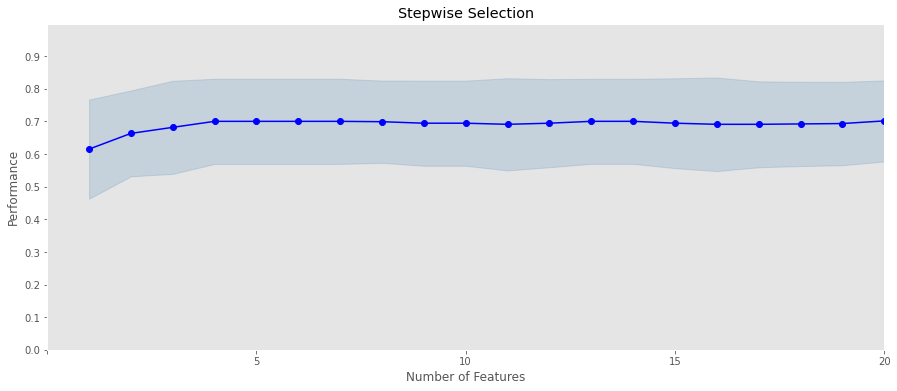

In [142]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [143]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [144]:
vars_FS_copy=deepcopy(vars_FS)

In [145]:
features = vars_FS['feature_names']

In [146]:
added = []
first = features[1]
prev = set(first)
added.append(list(prev)[0])
for i in features[1:]:
    i = set(i)
    diff = i - prev
    prev = i
    added.append(list(diff)[0])
vars_FS_copy['variable_added']=added
vars_FS_copy

feature_idx                                          cv_scores avg_score                                      feature_names  ci_bound   std_dev   std_err               variable_added
1                                                (2,)  [0.4482758620689655, 0.5402298850574713, 0.827...   0.61525                                (card-zip_total_3,)  0.112829  0.151915  0.050638             card-zip_total_3
2                                             (2, 29)  [0.6206896551724138, 0.5517241379310345, 0.735...  0.663512              (card-zip_total_3, card-state_max_14)  0.097795  0.131672  0.043891            card-state_max_14
3                                          (2, 5, 29)  [0.4482758620689655, 0.5632183908045977, 0.793...   0.68205  (card-zip_total_3, card-state_total_3, card-st...  0.106001  0.142722  0.047574           card-state_total_3
4                                      (2, 5, 29, 52)  [0.4942528735632184, 0.6436781609195402, 0.804...  0.700454  (card-zip_total_3, card-state_total_3, card-st...  0.096982  0.130578  0.043526            card-state_max_30
5                                  (2, 5, 29, 33, 52)  [0.4942528735632184, 0.6436781609195402, 0.804...  0.700454  (card-zip_total_3, card-state_total_3, card-st...  0.096982  0.130578  0.043526             card-zip_total_0
6                              (2, 5, 29, 33, 34, 52)  [0.4942528735632184, 0.6436781609195402, 0.804...  0.700454  (card-zip_total_3, card-state_total_3, card-st...  0.096982  0.130578  0.043526           card-merch_total_0
7                          (2, 5, 29, 33, 34, 35, 52)  [0.4942528735632184, 0.6436781609195402, 0.804...  0.700454  (card-zip_total_3, card-state_total_3, card-st...  0.096982  0.130578  0.043526           card-state_total_0
8                       (2, 5, 8, 29, 33, 34, 35, 52)  [0.5172413793103449, 0.5977011494252874, 0.781...  0.699345  (card-zip_total_3, card-state_total_3, card-st...  0.093646  0.126087  0.042029          card-state_total_14
9                   (2, 5, 8, 29, 33, 34, 35, 51, 52)  [0.5402298850574713, 0.5977011494252874, 0.781...  0.694747  (card-zip_total_3, card-state_total_3, card-st...  0.096978  0.130573  0.043524              card-zip_avg_30
10              (2, 5, 8, 29, 33, 34, 35, 51, 52, 70)  [0.5402298850574713, 0.5977011494252874, 0.781...  0.694747  (card-zip_total_3, card-state_total_3, card-st...  0.096978  0.130573  0.043524             card-state_avg_7
11          (2, 5, 8, 29, 33, 34, 35, 44, 51, 52, 70)  [0.47126436781609193, 0.5862068965517241, 0.78...  0.691312  (card-zip_total_3, card-state_total_3, card-st...     0.105  0.141374  0.047125           merchnum-zip_max_0
12      (2, 5, 8, 29, 33, 34, 35, 40, 44, 51, 52, 70)  [0.5057471264367817, 0.5862068965517241, 0.781...  0.694761  (card-zip_total_3, card-state_total_3, card-st...  0.100287  0.135028  0.045009    merchnum-merchstate_max_0
13   (2, 5, 8, 9, 29, 33, 34, 35, 40, 44, 51, 52, 70)  [0.5172413793103449, 0.632183908045977, 0.7816...  0.700508  (card-zip_total_3, card-state_total_3, card-st...  0.096813  0.130351   0.04345             card-zip_total_1
14  (2, 5, 8, 9, 29, 33, 34, 35, 40, 44, 51, 52, 5...  [0.5172413793103449, 0.632183908045977, 0.7816...  0.700508  (card-zip_total_3, card-state_total_3, card-st...  0.096813  0.130351   0.04345               Merchnum_max_0
15  (2, 5, 8, 9, 29, 33, 34, 35, 40, 44, 51, 52, 5...  [0.4827586206896552, 0.6206896551724138, 0.781...  0.694774  (card-zip_total_3, card-state_total_3, card-st...  0.102359  0.137818  0.045939              card-zip_avg_60
16  (2, 5, 8, 9, 27, 29, 33, 34, 35, 40, 44, 51, 5...  [0.4482758620689655, 0.6206896551724138, 0.781...  0.691326  (card-zip_total_3, card-state_total_3, card-st...  0.106503  0.143398  0.047799          card-state_total_30
17  (2, 5, 8, 9, 27, 29, 33, 34, 35, 40, 44, 51, 5...  [0.45977011494252873, 0.632183908045977, 0.712...  0.691353  (card-zip_total_3, card-state_total_3, card-st...  0.097851  0.131748  0.043916  merchnum-merchstate_

In [147]:
ordered_vars_FS = vars_FS_copy

In [148]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [149]:
ordered_vars_FS['variable_added']

1                card-zip_total_3
2               card-state_max_14
3              card-state_total_3
4               card-state_max_30
5                card-zip_total_0
6              card-merch_total_0
7              card-state_total_0
8             card-state_total_14
9                 card-zip_avg_30
10               card-state_avg_7
11             merchnum-zip_max_0
12      merchnum-merchstate_max_0
13               card-zip_total_1
14                 Merchnum_max_0
15                card-zip_avg_60
16            card-state_total_30
17    merchnum-merchstate_total_0
18               Merchnum_total_1
19               card-state_avg_3
20    merchnum-merchstate_total_1
Name: variable_added, dtype: object

In [150]:
vars_keep = ordered_vars_FS['variable_added']
vars_keep_list = ordered_vars_FS['variable_added'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [151]:
vars_keep

1                card-zip_total_3
2               card-state_max_14
3              card-state_total_3
4               card-state_max_30
5                card-zip_total_0
6              card-merch_total_0
7              card-state_total_0
8             card-state_total_14
9                 card-zip_avg_30
10               card-state_avg_7
11             merchnum-zip_max_0
12      merchnum-merchstate_max_0
13               card-zip_total_1
14                 Merchnum_max_0
15                card-zip_avg_60
16            card-state_total_30
17    merchnum-merchstate_total_0
18               Merchnum_total_1
19               card-state_avg_3
20    merchnum-merchstate_total_1
Name: variable_added, dtype: object

In [152]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card-zip_total_3',
 'card-state_max_14',
 'card-state_total_3',
 'card-state_max_30',
 'card-zip_total_0',
 'card-merch_total_0',
 'card-state_total_0',
 'card-state_total_14',
 'card-zip_avg_30',
 'card-state_avg_7',
 'merchnum-zip_max_0',
 'merchnum-merchstate_max_0',
 'card-zip_total_1',
 'Merchnum_max_0',
 'card-zip_avg_60',
 'card-state_total_30',
 'merchnum-merchstate_total_0',
 'Merchnum_total_1',
 'card-state_avg_3',
 'merchnum-merchstate_total_1',
 'Recnum',
 'Fraud']

In [153]:
df = deepcopy(data)

In [154]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [155]:
df_keep.head()

card-zip_total_3  card-state_max_14  card-state_total_3  card-state_max_30  card-zip_total_0  card-merch_total_0  card-state_total_0  card-state_total_14  card-zip_avg_30  card-state_avg_7  merchnum-zip_max_0  merchnum-merchstate_max_0  card-zip_total_1  Merchnum_max_0  card-zip_avg_60  card-state_total_30  merchnum-merchstate_total_0  Merchnum_total_1  card-state_avg_3  merchnum-merchstate_total_1  Recnum  Fraud
0              3.62               3.62                3.62               3.62              3.62                3.62                3.62                 3.62             3.62              3.62                3.62                       3.62              3.62            3.62             3.62                 3.62                         3.62              3.62              3.62                         3.62       1      0
1             31.42              31.42               31.42              31.42             31.42               31.42               31.42                31.42            31.42             31.42               31.42                      31.42             31.42           31.42            31.42                31.42                        31.42             31.42             31.42                        31.42       2      0
2            178.49             178.49              178.49             178.49            178.49              178.49              178.49               178.49           178.49            178.49              178.49                     178.49            178.49          178.49           178.49               178.49                       178.49            178.49            178.49                       178.49       3      0
3              3.62               3.62                3.62               3.62              3.62                3.62                3.62                 3.62             3.62              3.62                3.62                       3.62              3.62            3.62             3.62                 3.62                         7.24              7.24              3.62                         7.24       4      0
4              7.24               3.62                7.24               3.62              7.24                7.24                7.24                 7.24             3.62              3.62                3.62                       3.62              7.24            3.62             3.62                 7.24                        10.86             10.86              3.62                        10.86       5      0

## Test different Models

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb

In [157]:
vars1 = deepcopy(df_keep)

In [158]:
#vars1.to_csv('vars1final.csv')

In [159]:
vars1 = pd.read_csv('vars_featured.csv')

/var/folders/d1/klrxc7x93hv0pzjdqy5_0qnm0000gn/T/ipykernel_36133/2690718804.py:1: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  vars1 = pd.read_csv('vars_featured.csv')


In [160]:
vars1 = vars1.drop('Unnamed: 0',axis=1)

In [161]:
del df_keep

In [162]:
vars_ = vars1

In [163]:
vars_=vars_[['card-zip_total_3',
 'card-state_max_14',
 'card-state_total_3',
 'card-state_max_30',
 'card-zip_total_0',
 'card-merch_total_0',
 'card-state_total_0',
 'card-state_total_14',
 'card-state_total_30',
 'card-zip_avg_60',
 'card-state_total_60',
 'card-state_avg_7',
 'merchnum-zip_avg_0',
 'merchnum-merchstate_avg_0',
 'merchnum-merchstate_total_1',
'Recnum',
'Fraud']]

In [164]:
# use this to cap variables. For some problems it helps
Clip = 10

In [165]:
vars_['Fraud'].sum()

1059

In [166]:
record_save = vars_['Recnum']
Y_save = pd.DataFrame(vars_.loc[:,'Fraud'])
Y_save.head()

Fraud
0      0
1      0
2      0
3      0
4      0

In [167]:
X_no_scaling = vars_.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

card-zip_total_3  card-state_max_14  card-state_total_3  card-state_max_30  card-zip_total_0  card-merch_total_0  card-state_total_0  card-state_total_14  card-state_total_30  card-zip_avg_60  card-state_total_60  card-state_avg_7  merchnum-zip_avg_0  merchnum-merchstate_avg_0  merchnum-merchstate_total_1
count      96397.000000       96397.000000        96397.000000       96397.000000      96397.000000        96397.000000        96397.000000         96397.000000         96397.000000     96397.000000         96397.000000      96397.000000        96397.000000               96397.000000                 96397.000000
mean         641.964298         604.937127          737.166739         709.383794        531.979184          528.956599          553.449011          1149.522422          1664.914964       405.471217          2498.814521        399.681702          395.290914                 395.289945                  1132.129804
std         4067.003610        1190.742873         4119.265148        1300.839653       2623.529221         2622.014215         2639.897442          4505.358024          5179.937661       770.880951          6641.431030        755.034917          760.974941                 758.935584                  4371.050525
min            0.010000           0.010000            0.010000           0.010000          0.010000            0.010000            0.010000             0.010000             0.010000         0.010000             0.170000          0.010000            0.010000                   0.010000                     0.010000
25%           58.290000          67.000000           65.490000          87.130000         47.320000           46.620000           49.060000           113.540000           167.000000        49.000000           236.400000         46.791429           39.920000                  39.950000                   117.990000
50%          185.560000         258.830000          216.550000         326.350000        160.910000          159.470000          169.000000           365.610000           539.150000       178.700000           792.750000        171.600000          159.000000                 159.120000                   396.670000
75%          556.410000         735.000000          658.750000         919.250000        495.900000          494.000000          514.680000          1092.000000          1603.960000       475.000000          2306.030000        465.995000          451.710000                 452.000000                  1141.700000
max       306633.410000       47900.000000       306633.410000       47900.000000     217467.180000       217467.180000       217467.180000        306633.410000        306633.410000     28392.840000        306633.410000      28392.840000        28392.840000               28392.840000                306633.410000

In [168]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [169]:
# push in any outlier values
cols = X.columns
X.loc[:,cols] = X[cols].clip(upper=Clip)
X.loc[:,cols] = X[cols].clip(lower=-1*Clip)
# X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

card-zip_total_3  card-state_max_14  card-state_total_3  card-state_max_30  card-zip_total_0  card-merch_total_0  card-state_total_0  card-state_total_14  card-state_total_30  card-zip_avg_60  card-state_total_60  card-state_avg_7  merchnum-zip_avg_0  merchnum-merchstate_avg_0  merchnum-merchstate_total_1
count      96397.000000       96397.000000        96397.000000       96397.000000      96397.000000        96397.000000        96397.000000         96397.000000         96397.000000     96397.000000         96397.000000      96397.000000        96397.000000               96397.000000                 96397.000000
mean          -0.012606          -0.011534           -0.012337          -0.010855         -0.011766           -0.011778           -0.011645            -0.011548            -0.009953        -0.008162            -0.007464         -0.007548           -0.007511                  -0.007430                    -0.011506
std            0.448359           0.794726            0.473185           0.821838          0.483848            0.482805            0.494709             0.585453             0.707715         0.844425             0.834523          0.857354            0.858602                   0.859848                     0.560015
min           -0.157845          -0.508025           -0.178953          -0.545320         -0.202769           -0.201733           -0.209644            -0.255143            -0.321414        -0.525971            -0.376221         -0.529342           -0.519440                  -0.520835                    -0.259004
25%           -0.143515          -0.451766           -0.163057          -0.478348         -0.184736           -0.183957           -0.191064            -0.229945            -0.289176        -0.462421            -0.340652         -0.467383           -0.466994                  -0.468208                    -0.232013
50%           -0.112221          -0.290665           -0.126386          -0.294451         -0.141439           -0.140917           -0.145630            -0.173996            -0.217332        -0.294172            -0.256882         -0.302081           -0.310511                  -0.311186                    -0.168257
75%           -0.021036           0.109228           -0.019037           0.161331         -0.013752           -0.013332           -0.014686            -0.012768            -0.011768         0.090194            -0.029028          0.087828            0.074141                   0.074723                     0.002189
max           10.000000          10.000000           10.000000          10.000000         10.000000           10.000000           10.000000            10.000000            10.000000        10.000000            10.000000         10.000000           10.000000                  10.000000                    10.000000

In [170]:
# separate data into modeling (traintest) and out of time
X_trntst = X[0:84300]
Y_trntst = Y_save[0:84300]
X_oot = X[84300:]
Y_oot = Y_save[84300:]

In [171]:
X_oot

card-zip_total_3  card-state_max_14  card-state_total_3  card-state_max_30  card-zip_total_0  card-merch_total_0  card-state_total_0  card-state_total_14  card-state_total_30  card-zip_avg_60  card-state_total_60  card-state_avg_7  merchnum-zip_avg_0  merchnum-merchstate_avg_0  merchnum-merchstate_total_1
84300         -0.123704          -0.377888           -0.107625           0.668965         -0.149844           -0.148777           -0.098344            -0.144699             0.118975        -0.345853             0.009125         -0.364595           -0.336977                  -0.337881                    -0.227238
84301         -0.107766          -0.373328           -0.129510          -0.422023         -0.125136           -0.185230           -0.132493            -0.209937            -0.282095        -0.393876             0.027721         -0.394474           -0.465411                  -0.466660                    -0.240189
84302          0.342939           1.202411            0.315477           1.020353          0.573548            0.575033            0.561859             0.196916             0.071774         2.116058            -0.069581          2.168136            2.156982                   2.162779                     0.730847
84303         -0.108671          -0.340071           -0.130404          -0.391581         -0.126539           -0.125460           -0.133887            -0.210754            -0.249309        -0.266541            -0.306305         -0.264467           -0.256633                  -0.257321                    -0.213251
84304         -0.008988           0.000397           -0.031985          -0.079928          0.027989            0.029158            0.019683            -0.120770            -0.204540         0.259364            -0.285090          0.272475            0.183494                   0.183988                    -0.008758
...                 ...                ...                 ...                ...               ...                 ...                 ...                  ...                  ...              ...                  ...               ...                 ...                        ...                          ...
96392         -0.136999          -0.436826           -0.158372          -0.480147         -0.170453           -0.169399           -0.177529            -0.236326            -0.305047        -0.289391            -0.321323         -0.417056           -0.408030                  -0.409126                    -0.239608
96393         -0.128649           0.655106            0.036192           0.519369         -0.157509           -0.156447           -0.164665             0.382118             0.232857        -0.059894             0.236739          0.057538           -0.363403                  -0.364379                    -0.231839
96394         -0.068454          -0.202711           -0.073255          -0.265847         -0.064196           -0.063080           -0.071930            -0.158503            -0.237359        -0.054368            -0.282651         -0.241018            1.379719                   1.383428                     1.063534
96395          0.383591           1.341258            0.355613           1.147448          0.636567            0.638087            0.624487             0.233612             0.208635         0.477598             0.529189          2.387106            2.374243                   2.380624                     1.049885
96396          0.792317           2.131092            0.759153           1.870435          0.008638            0.009795            0.000451             0.602571             1.065371         0.727231             0.705368          0.750162            0.209401                   0.209965                    -0.132117

[12097 rows x 15 columns]

In [172]:
niter = 0
nitermax = 3
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

### Logistic Regression

In [235]:
from sklearn.metrics import make_scorer
def custom_FDR(y_true, y_scores):
    res_df = pd.DataFrame({'score':y_scores,'label': y_true}).sort_values(by='score',ascending=False)
    top3_res1 = res_df.head(round(y_true.shape[0]*0.03))
    return (top3_res1['label'].sum()/sum(y_true))

my_fdr_metric = make_scorer(custom_FDR, greater_is_better=True,needs_proba = True)

In [236]:
%%time
# Logistic regression

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(solver='liblinear',penalty='l1', C=1)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.6579804560260586 0.6541353383458647 0.3240223463687151
1 0.642504118616145 0.673992673992674 0.30726256983240224
2 0.6694078947368421 0.6433823529411765 0.2849162011173184
trn    0.656631
tst    0.657170
oot    0.305400
dtype: float64
CPU times: user 21.8 s, sys: 728 ms, total: 22.6 s
Wall time: 20.9 s


### Models. You can comment out any of these cells and just explore one model type. You can also just rerun that single cell multiple times as you explore different model hyperparameters.

In [237]:
%%time
# Single DT

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=None,min_samples_leaf=79,min_samples_split=1350,splitter='random')
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.6583850931677019 0.6567796610169492 0.3854748603351955
1 0.6505823627287853 0.6236559139784946 0.3743016759776536
2 0.6925619834710743 0.6472727272727272 0.29608938547486036
trn    0.667176
tst    0.642569
oot    0.351955
dtype: float64
CPU times: user 614 ms, sys: 238 ms, total: 852 ms
Wall time: 205 ms


#### Random Forest

In [238]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict

In [239]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [249]:
# You can set hypermarameters here. This code sets hyperparameters to 12 different models 
#for max_features, n_estimators and max_depth
param1=[]
for i in range(100,300,50):
    for j in range(60,90,10):
        param1.append([14,i,j])

In [250]:
def fdr_RF(model,X_data,Y_data):
    Y_data = pd.DataFrame(Y_data)
    Y_data['Fraud Proba'] = model.predict_proba(X_data)[:,1].tolist()
    Y_data = Y_data.sort_values(by='Fraud Proba',ascending=False)
    total_bads = Y_data['Fraud'][Y_data['Fraud']==1].count()
    top_rows = int(len(X_data)*.03)
    sum_bads = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==1].count()
    fdr = sum_bads/total_bads
    return fdr*100

In [251]:
#This code makes a list of the models that we can iterate through to get the required values
randomforests=[RandomForestClassifier(max_features = i[0],n_estimators = i[1],max_depth=i[2])for i in param1]

In [252]:
import warnings
warnings.filterwarnings("ignore")

In [253]:
results_dict_RF = {}

In [258]:
#This cell calculates the FDR for all 3 models and each model's average score is iterated
#through nitermax to get the average score
for index,randomforest in enumerate(randomforests):
    model_name = "random_forest_"+str(index+1)
    results_dict_RF[model_name] = {'fdr':{}}
    FDR_3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    for niter in range(nitermax):
        X_train,X_test,Y_train,Y_test = train_test_split(X_trntst, Y_trntst['Fraud'],train_size=0.7,test_size = 0.30)
        X_oot = X_oot_orig.copy()
        randomforest.fit(X_train,Y_train.values.ravel())
# calculate fdr for training, testing, and validation sets
        results_dict_RF[model_name]['fdr']['train_fdr_30']=fdr_RF(randomforest,X_train, Y_train)
        results_dict_RF[model_name]['fdr']['test_fdr_30']=fdr_RF(randomforest,X_test,Y_test)
        results_dict_RF[model_name]['fdr']['oot_fdr_30']=fdr_RF(randomforest,X_oot,Y_oot)
        FDR_3.loc[niter, 'trn'] = results_dict_RF[model_name]['fdr']['train_fdr_30']
        FDR_3.loc[niter, 'tst']=results_dict_RF[model_name]['fdr']['test_fdr_30']
        FDR_3.loc[niter, 'oot']=results_dict_RF[model_name]['fdr']['oot_fdr_30']
        
    print("Done with:",model_name, ";  time:",pd.datetime.now()-curr_time)
    print("Average score for:",model_name,"\n" ,FDR_3.mean())

Done with: random_forest_1 ;  time: 0:44:14.807402
Average score for: random_forest_1 
 trn    100.000000
tst     81.744012
oot     47.486034
dtype: float64
Done with: random_forest_2 ;  time: 0:47:23.926174
Average score for: random_forest_2 
 trn    100.000000
tst     82.559488
oot     47.113594
dtype: float64
Done with: random_forest_3 ;  time: 0:50:29.055342
Average score for: random_forest_3 
 trn    100.000000
tst     81.234831
oot     48.230912
dtype: float64
Done with: random_forest_4 ;  time: 0:54:56.646669
Average score for: random_forest_4 
 trn    100.000000
tst     83.031529
oot     47.113594
dtype: float64
Done with: random_forest_5 ;  time: 0:59:34.855887
Average score for: random_forest_5 
 trn    100.000000
tst     82.412083
oot     48.417132
dtype: float64
Done with: random_forest_6 ;  time: 1:04:12.903219
Average score for: random_forest_6 
 trn    100.000000
tst     83.923369
oot     48.789572
dtype: float64
Done with: random_forest_7 ;  time: 1:10:20.647635
Average

#### Neural Network

In [259]:
%%time
# NN
nitermax=3
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(90))

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.8244766505636071 0.7683397683397684 0.5865921787709497
1 0.8098256735340729 0.8032128514056225 0.6145251396648045
2 0.8380634390651085 0.8113879003558719 0.4301675977653631
trn    0.824122
tst    0.794314
oot    0.543762
dtype: float64
CPU times: user 9min 38s, sys: 2min 26s, total: 12min 4s
Wall time: 2min 33s


### Final model

In [173]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
model = MLPClassifier(hidden_layer_sizes=(90))

X_oot = X_oot_orig.copy()
X_trn_save = X_trn.copy()
Y_trn_save = Y_trn.copy()

model.fit(X_trn, Y_trn.values.ravel())   

predictions = model.predict_proba(X_trn_save)[:,1]
X_trn['predicted'] = predictions
X_trn['Fraud'] = Y_trn_save['Fraud']
topRows = int(round(X_trn.shape[0]*0.03))
temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
needed = temp.loc[:,'Fraud']
FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

predictions = model.predict_proba(X_tst)[:,1]
X_tst['predicted']=predictions
X_tst['Fraud'] = Y_tst['Fraud']
topRows = int(round(X_tst.shape[0]*0.03))
temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
needed = temp.loc[:,'Fraud']
FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

predictions = model.predict_proba(X_oot)[:,1]
X_oot['predicted']=predictions
X_oot['Fraud'] = Y_oot['Fraud']
topRows = int(round(X_oot.shape[0]*0.03))
temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
needed = temp.loc[:,'Fraud']
FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])

0 0.8244766505636071 0.7799227799227799 0.5921787709497207


In [174]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

### Final table

In [175]:
def output_table(y_res_valid,Y_valid):
# returs the output tables
# y_res_valis is y_pred
# Y_valid is y_true
# returns:
# cumulative dataset, Bin Statistics
    no_of_bads =Y_valid.sum()
    no_of_records = len(Y_valid)
    no_of_goods = no_of_records - no_of_bads
    print('no_of_records',no_of_records)
    print('No of bads',no_of_bads)
    print('no_of_goods',no_of_goods)

    fin_tabl_df = pd.DataFrame({'score':y_res_valid,'label': Y_valid}).sort_values(by='score',ascending=False)
    df_pres_cum = pd.DataFrame(columns=['Total # Records','# Goods','# Bads'])
    for i_tbl_df in range(1,21): #21 is the final
    #     print(i_tbl_df)
        top3_res2 = fin_tabl_df.head(round(Y_valid.shape[0]*(i_tbl_df/100)))
        top3_res2#['label'].sum()/sum(Y_valid)
    #     print('No of records:',top3_res2.shape[0])
        df_pres_cum.loc[i_tbl_df-1,'Total # Records'] = top3_res2.shape[0]
    #     print('No of bads:',top3_res2['label'].sum())
        df_pres_cum.loc[i_tbl_df-1,'# Bads'] = top3_res2['label'].sum()
    #     print('No of goods:',top3_res2.shape[0]- top3_res2['label'].sum())
        df_pres_cum.loc[i_tbl_df-1,'# Goods'] = top3_res2.shape[0]- top3_res2['label'].sum()

    df_pres = df_pres_cum.diff()
    df_pres.loc[0] = df_pres_cum.loc[0]
    df_pres = df_pres.rename(columns={"Total # Records": "# Records"})
    df_pres['% Goods'] = 100*(df_pres['# Goods']/df_pres['# Records'])
    df_pres['% Bads'] = 100*(df_pres['# Bads']/df_pres['# Records'])
    print('Bin statistics')
    df_pres.to_csv('Test_Bin_stats.csv')
    display(df_pres)

    df_pres_cum['% Goods'] = 100*(df_pres_cum['# Goods']/no_of_goods)
    df_pres_cum['% Bads'] = 100*(df_pres_cum['# Bads']/no_of_bads)
    df_pres_cum['KS'] = df_pres_cum['% Bads'] - df_pres_cum['% Goods']
    df_pres_cum['FPR'] = df_pres_cum['# Goods']/df_pres_cum['# Bads']
    df_pres_cum = df_pres_cum.rename(columns={"# Goods": "Cumulative Goods",'# Bads':'Cumulative Bads','% Bads':'% Bads (FDR)'})
    print('Cumulative results')
    # df_pres_cum.to_csv(path+'Test_Cum_stats.csv') To save into a csv file
    display(df_pres_cum)
    return df_pres_cum, df_pres

In [176]:
# X_trntst = X[0:84300]
# Y_trntst = Y_save[0:84300]
# X_oot = X[84300:]
# Y_oot = Y_save[84300:]

In [177]:
Y_trn['Fraud Proba'] =  model.predict_proba(X_trn_save)[:,1].tolist()
Y_tst['Fraud Proba'] =  model.predict_proba(X_tst.iloc[:,:15])[:,1].tolist()
Y_oot['Fraud Proba'] =  model.predict_proba(X_oot.iloc[:,:15])[:,1].tolist()

In [238]:
df1 = pd.concat([df.iloc[:,:10], pd.concat([Y_trn, Y_tst, Y_oot])], axis=1)

In [205]:
df1.Cardnum = df1.Cardnum.astype(str)

In [206]:
output_table(Y_trn['Fraud Proba'],Y_trn['Fraud'])

no_of_records 59010
No of bads 621
no_of_goods 58389
Bin statistics


# Records # Goods # Bads    % Goods     % Bads
0        590     171    419  28.983051  71.016949
1        590     513     77  86.949153  13.050847
2        590     574     16  97.288136   2.711864
3        590     583      7  98.813559   1.186441
4        590     579     11  98.135593   1.864407
5        591     582      9  98.477157   1.522843
6        590     587      3  99.491525   0.508475
7        590     587      3  99.491525   0.508475
8        590     587      3  99.491525   0.508475
9        590     589      1  99.830508   0.169492
10       590     581      9  98.474576   1.525424
11       590     588      2  99.661017   0.338983
12       590     589      1  99.830508   0.169492
13       590     584      6  98.983051   1.016949
14       591     589      2  99.661591   0.338409
15       590     587      3  99.491525   0.508475
16       590     588      2  99.661017   0.338983
17       590     589      1  99.830508   0.169492
18       590     587      3  99.491525   0.508475
19       590     585      5  99.152542   0.847458

Cumulative results


Total # Records Cumulative Goods Cumulative Bads    % Goods % Bads (FDR)         KS        FPR
0              590              171             419   0.292863     67.47182  67.178956   0.408115
1             1180              684             496   1.171454    79.871176  78.699722   1.379032
2             1770             1258             512   2.154515    82.447665   80.29315   2.457031
3             2360             1841             519   3.152991    83.574879  80.421888   3.547206
4             2950             2420             530   4.144616    85.346216    81.2016   4.566038
5             3541             3002             539   5.141379    86.795491  81.654112   5.569573
6             4131             3589             542   6.146706    87.278583  81.131877   6.621771
7             4721             4176             545   7.152032    87.761675  80.609643   7.662385
8             5311             4763             548   8.157358    88.244767  80.087408   8.691606
9             5901             5352             549    9.16611    88.405797  79.239687   9.748634
10            6491             5933             558   10.16116    89.855072  79.693912  10.632616
11            7081             6521             560  11.168199    90.177134  79.008934  11.644643
12            7671             7110             561  12.176951    90.338164  78.161213  12.673797
13            8261             7694             567   13.17714    91.304348  78.127208  13.569665
14            8852             8283             569  14.185891    91.626409  77.440518  14.557118
15            9442             8870             572  15.191218    92.109501  76.918283  15.506993
16           10032             9458             574  16.198257    92.431562  76.233305  16.477352
17           10622            10047             575  17.207008    92.592593  75.385584  17.473043
18           11212            10634             578  18.212335    93.075684   74.86335  18.397924
19           11802            11219             583  19.214236    93.880837  74.666602  19.243568

(   Total # Records Cumulative Goods Cumulative Bads    % Goods % Bads (FDR)         KS        FPR
 0              590              171             419   0.292863     67.47182  67.178956   0.408115
 1             1180              684             496   1.171454    79.871176  78.699722   1.379032
 2             1770             1258             512   2.154515    82.447665   80.29315   2.457031
 3             2360             1841             519   3.152991    83.574879  80.421888   3.547206
 4             2950             2420             530   4.144616    85.346216    81.2016   4.566038
 5             3541             3002             539   5.141379    86.795491  81.654112   5.569573
 6             4131             3589             542   6.146706    87.278583  81.131877   6.621771
 7             4721             4176             545   7.152032    87.761675  80.609643   7.662385
 8             5311             4763             548   8.157358    88.244767  80.087408   8.691606
 9        

In [207]:
output_table(Y_tst['Fraud Proba'],Y_tst['Fraud'])

no_of_records 25290
No of bads 259
no_of_goods 25031
Bin statistics


# Records # Goods # Bads    % Goods     % Bads
0        253      97    156  38.339921  61.660079
1        253     215     38  84.980237  15.019763
2        253     245      8  96.837945   3.162055
3        253     245      8  96.837945   3.162055
4        252     249      3  98.809524   1.190476
5        253     250      3  98.814229   1.185771
6        253     251      2  99.209486   0.790514
7        253     250      3  98.814229   1.185771
8        253     250      3  98.814229   1.185771
9        253     252      1  99.604743   0.395257
10       253     247      6  97.628458   2.371542
11       253     251      2  99.209486   0.790514
12       253     252      1  99.604743   0.395257
13       253     253      0      100.0        0.0
14       253     253      0      100.0        0.0
15       252     249      3  98.809524   1.190476
16       253     253      0      100.0        0.0
17       253     251      2  99.209486   0.790514
18       253     253      0      100.0        0.0
19       253     252      1  99.604743   0.395257

Cumulative results


Total # Records Cumulative Goods Cumulative Bads    % Goods % Bads (FDR)         KS        FPR
0              253               97             156   0.387519     60.23166  59.844141   0.621795
1              506              312             194   1.246454    74.903475  73.657021   1.608247
2              759              557             202   2.225241    77.992278  75.767037   2.757426
3             1012              802             210   3.204027    81.081081  77.877054   3.819048
4             1264             1051             213   4.198793    82.239382  78.040589   4.934272
5             1517             1301             216   5.197555    83.397683  78.200128   6.023148
6             1770             1552             218   6.200312    84.169884  77.969573   7.119266
7             2023             1802             221   7.199073    85.328185  78.129112   8.153846
8             2276             2052             224   8.197835    86.486486  78.288652   9.160714
9             2529             2304             225   9.204586    86.872587  77.668001      10.24
10            2782             2551             231  10.191363    89.189189  78.997826   11.04329
11            3035             2802             233  11.194119     89.96139  78.767271  12.025751
12            3288             3054             234  12.200871     90.34749  78.146619  13.051282
13            3541             3307             234  13.211618     90.34749  77.135873  14.132479
14            3794             3560             234  14.222364     90.34749  76.125126  15.213675
15            4046             3809             237  15.217131    91.505792  76.288661   16.07173
16            4299             4062             237  16.227877    91.505792  75.277914  17.139241
17            4552             4313             239  17.230634    92.277992  75.047358  18.046025
18            4805             4566             239  18.241381    92.277992  74.036612  19.104603
19            5058             4818             240  19.248132    92.664093   73.41596     20.075

(   Total # Records Cumulative Goods Cumulative Bads    % Goods % Bads (FDR)         KS        FPR
 0              253               97             156   0.387519     60.23166  59.844141   0.621795
 1              506              312             194   1.246454    74.903475  73.657021   1.608247
 2              759              557             202   2.225241    77.992278  75.767037   2.757426
 3             1012              802             210   3.204027    81.081081  77.877054   3.819048
 4             1264             1051             213   4.198793    82.239382  78.040589   4.934272
 5             1517             1301             216   5.197555    83.397683  78.200128   6.023148
 6             1770             1552             218   6.200312    84.169884  77.969573   7.119266
 7             2023             1802             221   7.199073    85.328185  78.129112   8.153846
 8             2276             2052             224   8.197835    86.486486  78.288652   9.160714
 9        

In [208]:
output_table(Y_oot['Fraud Proba'],Y_oot['Fraud'])

no_of_records 12097
No of bads 179
no_of_goods 11918
Bin statistics


# Records # Goods # Bads    % Goods     % Bads
0        121      38     83  31.404959  68.595041
1        121     103     18  85.123967  14.876033
2        121     116      5  95.867769   4.132231
3        121     113      8   93.38843    6.61157
4        121     120      1  99.173554   0.826446
5        121     119      2  98.347107   1.652893
6        121     119      2  98.347107   1.652893
7        121     120      1  99.173554   0.826446
8        121     120      1  99.173554   0.826446
9        121     119      2  98.347107   1.652893
10       121     116      5  95.867769   4.132231
11       121     119      2  98.347107   1.652893
12       121     118      3  97.520661   2.479339
13       121     117      4  96.694215   3.305785
14       121     118      3  97.520661   2.479339
15       121     118      3  97.520661   2.479339
16       120     118      2  98.333333   1.666667
17       121     121      0      100.0        0.0
18       121     121      0      100.0        0.0
19       121     121      0      100.0        0.0

Cumulative results


Total # Records Cumulative Goods Cumulative Bads    % Goods % Bads (FDR)         KS        FPR
0              121               38              83   0.318845    46.368715   46.04987   0.457831
1              242              141             101   1.183084    56.424581  55.241497    1.39604
2              363              257             106   2.156402    59.217877  57.061475   2.424528
3              484              370             114   3.104548    63.687151  60.582603   3.245614
4              605              490             115   4.111428     64.24581  60.134382    4.26087
5              726              609             117   5.109918    65.363128  60.253211   5.205128
6              847              728             119   6.108407    66.480447  60.372039   6.117647
7              968              848             120   7.115288    67.039106  59.923818   7.066667
8             1089              968             121   8.122168    67.597765  59.475597        8.0
9             1210             1087             123   9.120658    68.715084  59.594426   8.837398
10            1331             1203             128  10.093975     71.50838  61.414404   9.398438
11            1452             1322             130  11.092465    72.625698  61.533233  10.169231
12            1573             1440             133  12.082564    74.301676  62.219112  10.827068
13            1694             1557             137  13.064273    76.536313   63.47204  11.364964
14            1815             1675             140  14.054372    78.212291  64.157919  11.964286
15            1936             1793             143  15.044471    79.888268  64.843798  12.538462
16            2056             1911             145   16.03457    81.005587  64.971017   13.17931
17            2177             2032             145  17.049841    81.005587  63.955746  14.013793
18            2298             2153             145  18.065112    81.005587  62.940475  14.848276
19            2419             2274             145  19.080383    81.005587  61.925204  15.682759

(   Total # Records Cumulative Goods Cumulative Bads    % Goods % Bads (FDR)         KS        FPR
 0              121               38              83   0.318845    46.368715   46.04987   0.457831
 1              242              141             101   1.183084    56.424581  55.241497    1.39604
 2              363              257             106   2.156402    59.217877  57.061475   2.424528
 3              484              370             114   3.104548    63.687151  60.582603   3.245614
 4              605              490             115   4.111428     64.24581  60.134382    4.26087
 5              726              609             117   5.109918    65.363128  60.253211   5.205128
 6              847              728             119   6.108407    66.480447  60.372039   6.117647
 7              968              848             120   7.115288    67.039106  59.923818   7.066667
 8             1089              968             121   8.122168    67.597765  59.475597        8.0
 9        

### Fraud Savings Cut-off Plot

In [209]:
# Function to calculate savings
# Assuming $2000 gain for every True Positive
def fraud_savings(model,X_data, Y_data,i):
    Y_data = pd.DataFrame(Y_data)
    Y_data['Fraud Proba'] = model.predict_proba(X_data)[:,1].tolist()
    Y_data = Y_data.sort_values(by='Fraud Proba',ascending=False)
    # total_bads = Y_data['Fraud'][Y_data['Fraud']==1].count()
    top_rows = int(len(X_data)*i*.01)
    sum_bads = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==1].count()
    # loss = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==0].count()
    fraud_savings = sum_bads*2000    
    return fraud_savings

In [210]:
# Function to calculate losses
# Assuming $50 loss for every False Positive
def fraud_losses(model,X_data, Y_data,i):
    Y_data = pd.DataFrame(Y_data)
    Y_data['Fraud Proba'] = model.predict_proba(X_data)[:,1].tolist()
    Y_data = Y_data.sort_values(by='Fraud Proba',ascending=False)
    # total_bads = Y_data['Fraud'][Y_data['Fraud']==1].count()
    top_rows = int(len(X_data)*i*.01)
    #sum_bads = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==1].count()
    loss = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==0].count()
    fraud_losses = loss*50   
    return fraud_losses

In [211]:
# Calculating savings for FDR till 50%
savings = {}
for j in range(0,51):
    savings[j] = fraud_savings(model,X_oot.iloc[:,:15],Y_oot,j)

In [212]:
# Calculating losses for FDR till 50%
losses = {}
for j in range(0,51):
    losses[j] = fraud_losses(model,X_oot.iloc[:,:15],Y_oot,j)

In [213]:
import seaborn as sns

In [214]:
# Calculating overall savings by subtracting losses from gains
overall_savings = {key: savings[key] - losses[key] for key in savings}

In [215]:
for key,value in overall_savings.items():
    if overall_savings[key]==195100:
        print(key)
        break

In [216]:
max(overall_savings.values())

209550

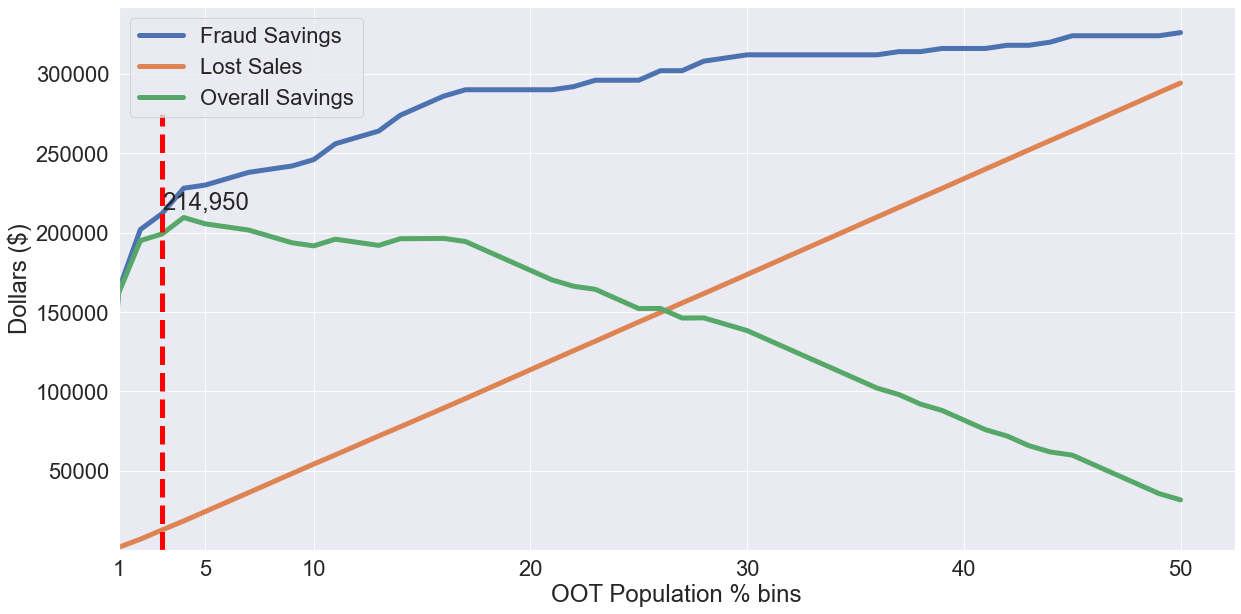

In [217]:
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (20,10)

sns.set(font_scale=2)
lists = sorted(savings.items()) # sorted by key, return a list of tuples
# loss = sorted(losses.items())
x, y = zip(*lists) # unpack a list of pairs into two tuples
x,z = zip(*losses.items())
x,b = zip(*overall_savings.items())
axes = plt.axes()
plt.plot(x, y, label='Fraud Savings', linewidth = 5)
plt.plot(x,z, label = 'Lost Sales', linewidth = 5)
plt.plot(x,b, label = 'Overall Savings', linewidth = 5)
plt.ylim(ymin=1)
plt.xlim(xmin=1)
plt.xlabel("OOT Population % bins")
plt.ylabel("Dollars ($)")
plt.vlines(x=3, ymin=0, ymax=275000, color='red', zorder=2, linestyles='dashed', linewidth = 5)
axes.set_xticks([1,5,10,20,30,40,50])
plt.annotate('214,950',(3,214950))
plt.legend()

plt.show()

In [218]:
print(f"Annualized savings = {overall_savings[3]*6}")

Annualized savings = 1195200


In [219]:
# 5142160778 - cardnum 9977060860500- merchnum

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
#import plotly.express as px  # fast interactive graphics
#import plotly.graph_objects as go
import matplotlib.dates as mdates

In [246]:
final_data=X_oot_eval.copy()

In [247]:
df_card = df1[df1['Cardnum']=='5142212038']

In [248]:
df_card

Recnum     Cardnum       Date       Merchnum        Merch description Merch state Merch zip Transtype   Amount  Fraud  Fraud  Fraud Proba
4989     4997  5142212038 2006-01-24  2365000737381      FED EMP NEWS DIGEST          VA   20191.0         P    24.75      0      0     0.000161
12035   12053  5142212038 2006-02-18   615679280335        RICOH CORPORATION          NJ    7006.0         P   112.50      0      0     0.000453
12067   12085  5142212038 2006-02-18   615679280335        RICOH CORPORATION          NJ    7006.0         P   128.50      0      0     0.001445
22065   22108  5142212038 2006-03-27   253050505632    U S CONGRESS HANDBOOK          VA   22101.0         P    16.95      0      0     0.000211
22169   22214  5142212038 2006-03-27  9108242310000            STAPLES #8489          NC   28273.0         P   194.45      0      0     0.000722
38080   38196  5142212038 2006-05-22  4353000719908   AMAZON.COM  *SUPERSTOR          WA   98101.0         P    70.26      0      0     0.000227
38854   38977  5142212038 2006-05-24  5725000466504       CDW*GOVERNMENT INC          IL   60061.0         P  1048.42      0      0     0.007748
53022   53209  5142212038 2006-07-14  5725000466504       CDW*GOVERNMENT INC          IL   60061.0         P   164.49      0      0     0.000304
53825   54014  5142212038 2006-07-18   930090121224   FEDEX SHP 07/08/10 AB#          TN   38118.0         P    34.59      1      1     0.000335
53826   54015  5142212038 2006-07-18   930090121224   FEDEX SHP 07/26/10 AB#          TN   38118.0         P    38.35      1      1     0.000474
53846   54035  5142212038 2006-07-18   930090121224   FEDEX SHP 07/08/10 AB#          TN   38118.0         P    38.23      1      1     0.000695
53880   54069  5142212038 2006-07-18   930090121224   FEDEX SHP 07/05/10 AB#          TN   38118.0         P    96.09      1      1     0.001647
53892   54081  5142212038 2006-07-18   930090121224   FEDEX SHP 07/25/10 AB#          TN   38118.0         P    38.99      1      1     0.002361
53895   54084  5142212038 2006-07-18   930090121224   FEDEX SHP 07/25/10 AB#          TN   38118.0         P    37.42      1      1     0.003351
53900   54089  5142212038 2006-07-18   930090121224   FEDEX SHP 07/13/10 AB#          TN   38118.0         P    31.52      1      1     0.004515
53922   54111  5142212038 2006-07-18   930090121224   FEDEX SHP 07/13/10 AB#          TN   38118.0         P    40.16      1      1     0.006687
53961   54150  5142212038 2006-07-18   930090121224   FEDEX SHP 07/08/10 AB#          TN   38118.0         P    31.02      1      1     0.008428
54019   54208  5142212038 2006-07-18   930090121224   FEDEX SHP 07/05/10 AB#          TN   38118.0         P    42.04      1      1     0.012244
54028   54217  5142212038 2006-07-18   930090121224   FEDEX SHP 07/25/10 AB#          TN   38118.0         P    31.72      1      1     0.014236
54075   54264  5142212038 2006-07-18   930090121224   FEDEX SHP 07/13/10 AB#          TN   38118.0         P    41.33      1      1     0.016961
54094   54283  5142212038 2006-07-18   930090121224   FEDEX SHP 07/13/10 AB#          TN   38118.0         P    34.24      1      1     0.019391
54099   54288  5142212038 2006-07-18   930090121224   FEDEX SHP 07/24/10 AB#          TN   38118.0         P    32.75      1      1     0.021516
54104   54293  5142212038 2006-07-18   930090121224   FEDEX SHP 07/05/10 AB#          TN   38118.0         P    83.85      1      1     0.028497
54118   54307  5142212038 2006-07-18   930090121224   FEDEX SHP 07/25/10 AB#          TN   38118.0         P    31.29      1      1     0.031138
54136   54326  5142212038 2006-07-18   930090121224   FEDEX SHP 07/13/10 AB#          TN   38118.0         P    39.08      1      1     0.032131
54161   54351  5142212038 2006-07-18   930090121224   FEDEX SHP 07/25/10 AB#          TN   38118.0         P    30.88      1      1     0.032731
54204   54394  5142212038 2006-07-19   930090121224   FEDEX SHP 07/13/10 AB#          TN   3

In [249]:
df_merch = df1[df1['Merchnum']=='965610600330']

Text(0.5, 1.0, 'Cardnum 5142160778')

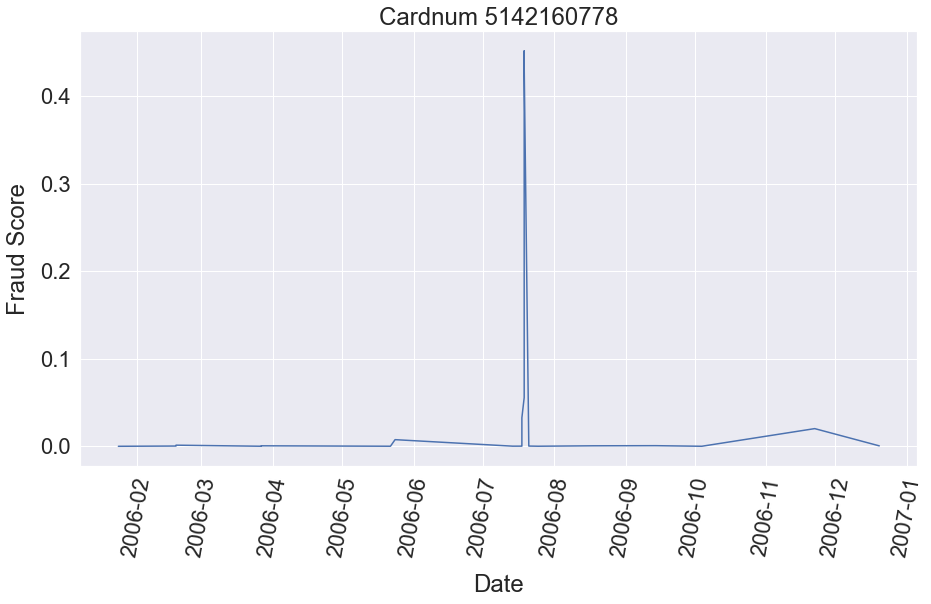

In [251]:
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['font.size'] = 22
fig = plt.figure()
ax = plt.axes()

plt.plot(df_card['Date'], df_card['Fraud Proba'])
months = mdates.MonthLocator()  # every month
ax.xaxis.set_major_locator(months)
plt.xticks(rotation='80')
plt.xlabel('Date', labelpad=15)
plt.ylabel('Fraud Score', labelpad=10)
plt.title("Cardnum 5142160778")

Text(0, 0.5, 'Fraud Score')

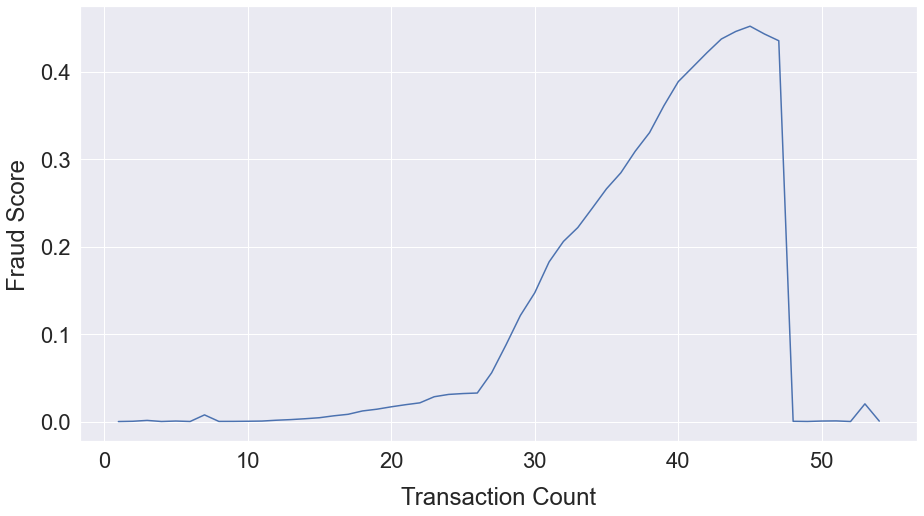

In [253]:
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['font.size'] = 22
fig = plt.figure()
ax = plt.axes()

plt.plot(range(1, len(df_card)+1), df_card['Fraud Proba'])
# plt.xticks()
plt.xlabel('Transaction Count', labelpad=15)
plt.ylabel('Fraud Score', labelpad=10)

Text(0.5, 1.0, 'Merchnum 5725000466504')

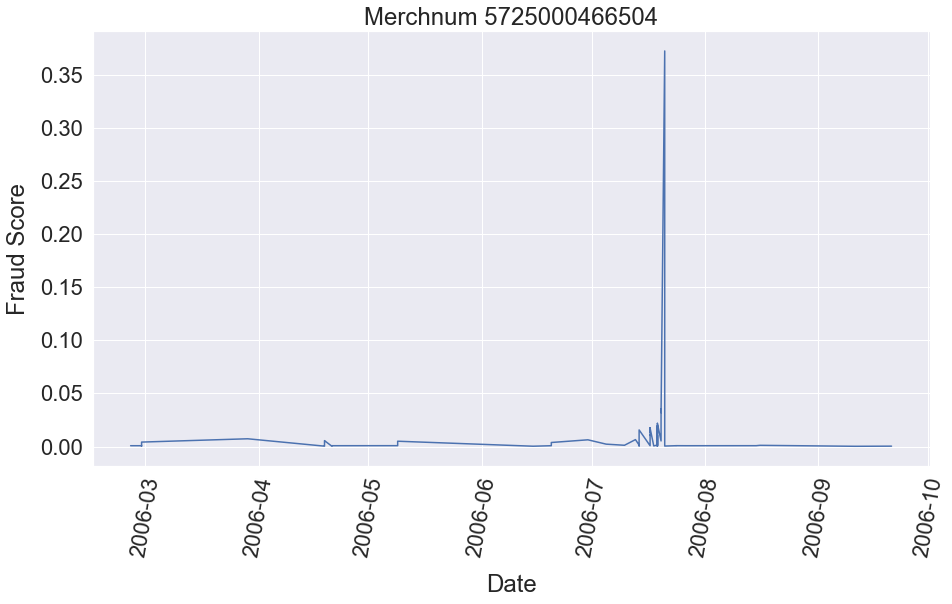

In [254]:
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['font.size'] = 22
fig = plt.figure()
ax = plt.axes()

plt.plot(df_merch['Date'], df_merch['Fraud Proba'])
months = mdates.MonthLocator()  # every month
ax.xaxis.set_major_locator(months)
plt.xticks(rotation='80')
plt.xlabel('Date', labelpad=15)
plt.ylabel('Fraud Score', labelpad=10)
plt.title("Merchnum 5725000466504")

In [255]:
final_data=X_oot_eval.copy()

In [256]:
final_data.sort_index(inplace=True)

In [257]:
data1=record_save[record_save.index>84300]
final_data['Recnum']=data1

In [259]:
final_data=final_data.merge(df_original, how='inner', on='Recnum', suffixes=('_x', '_y'))

In [260]:
final_data

card-zip_total_3  card-state_max_14  card-state_total_3  card-state_max_30  card-zip_total_0  card-merch_total_0  card-state_total_0  card-state_total_14  card-state_total_30  card-zip_avg_60  card-state_total_60  card-state_avg_7  merchnum-zip_avg_0  merchnum-merchstate_avg_0  merchnum-merchstate_total_1     predicted  Fraud_x   Recnum     Cardnum        Date       Merchnum          Merch description Merch state  Merch zip Transtype   Amount  Fraud_y
0             -0.107766          -0.373328           -0.129510          -0.422023         -0.125136           -0.185230           -0.132493            -0.209937            -0.282095        -0.393876             0.027721         -0.394474           -0.465411                  -0.466660                    -0.240189  3.836379e-04        0  84631.0  5142160778  2006-11-02  9495001630090  WOLF CAMERA MAIN SHRM #61          GA    30318.0         P    43.28        0
1              0.342939           1.202411            0.315477           1.020353          0.573548            0.575033            0.561859             0.196916             0.071774         2.116058            -0.069581          2.168136            2.156982                   2.162779                     0.730847  6.882420e-03        0  84632.0  5142251947  2006-11-02  9900020008506      UNICOR FED PRISON IND          KY        NaN         P  2036.70        0
2             -0.108671          -0.340071           -0.130404          -0.391581         -0.126539           -0.125460           -0.133887            -0.210754            -0.249309        -0.266541            -0.306305         -0.264467           -0.256633                  -0.257321                    -0.213251  7.582111e-04        0  84633.0  5142139622  2006-11-02  5600800005397                 APHA HQ DC          DC    20005.0         P   200.00        0
3             -0.008988           0.000397           -0.031985          -0.079928          0.027989            0.029158            0.019683            -0.120770            -0.204540         0.259364            -0.285090          0.272475            0.183494                   0.183988                    -0.008758  4.564637e-03        0  84634.0  5142180447  2006-11-02   806967335334     LAB SAFETY SUPPLY, INC          WI    53546.0         P   605.41        0
4             -0.152042           0.894427            0.073536           0.738436         -0.193773           -0.192732            0.184337             0.346371             0.202359        -0.495357             1.401476          0.159408           -0.394767                  -0.395826                    -0.193885  9.316461e-07        0  84635.0  5142289546  2006-11-02   602608969534             FISHER SCI ATL          GA    30091.0         P    23.61        0
...                 ...                ...                 ...                ...               ...                 ...                 ...                  ...                  ...              ...                  ...               ...                 ...                        ...                          ...           ...      ...      ...         ...         ...            ...                        ...         ...        ...       ...      ...      ...
12091         -0.136999          -0.436826           -0.158372          -0.480147         -0.170453           -0.169399           -0.177529            -0.236326            -0.305047        -0.289391            -0.321323         -0.417056           -0.408030                  -0.409126                    -0.239608  5.951826e-04        0  96749.0  5142276053  2006-12-31  3500000006160     BEST BUY      00001610          KY    41042.0         P    84.79        0
12092         -0.128649           0.655106            0.036192           0.519369         -0.157509           -0.156447           -0.164665             0.382118             0.232857        -0.059894             0.236739          0.057538           -0.363403                  -0.364379                   

In [261]:
(final_data['Fraud_x']!=final_data['Fraud_y']).sum()

0

In [262]:
final_data.columns

Index(['card-zip_total_3', 'card-state_max_14', 'card-state_total_3', 'card-state_max_30', 'card-zip_total_0', 'card-merch_total_0', 'card-state_total_0', 'card-state_total_14', 'card-state_total_30', 'card-zip_avg_60', 'card-state_total_60', 'card-state_avg_7', 'merchnum-zip_avg_0', 'merchnum-merchstate_avg_0', 'merchnum-merchstate_total_1', 'predicted', 'Fraud_x', 'Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description', 'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud_y'], dtype='object')

In [263]:
final_data=final_data[['Recnum', 'Cardnum', 'Date', 'Merchnum',
       'Merch description', 'Merch state', 'Merch zip', 'Transtype', 'Amount','predicted',
       'Fraud_y']]

In [267]:
Cardnumgraph=final_data[final_data['Cardnum'].astype(str)=='5142160778']

In [275]:
Cardnumgraph['Date']=Cardnumgraph['Date'].apply(lambda x: x.strftime('%m-%d'))

In [276]:
Cardnumgraph

Recnum     Cardnum   Date       Merchnum          Merch description Merch state  Merch zip Transtype   Amount  predicted  Fraud_y
0      84631.0  5142160778  11-02  9495001630090  WOLF CAMERA MAIN SHRM #61          GA    30318.0         P    43.28   0.000384        0
954    85592.0  5142160778  11-05   975965506226    SIMPSONWOOD RETREAT CTR          GA    30092.0         P   439.67   0.001086        0
1838   86483.0  5142160778  11-10   465906156333    SYNERGY OFFICE PRODUCTS          GA    30303.0         P    16.24   0.000094        0
2216   86861.0  5142160778  11-12          95581     GOODYEAR      00025536          GA    30308.0         P  1219.42   0.000435        0
3356   88001.0  5142160778  11-18  4503056565500            COMPUSA #497 MO          GA    30326.0         P   151.72   0.000058        0
4594   89239.0  5142160778  11-24  9010893640066         ECKERD DRUGS #3291          GA    30073.0         P    18.45   0.000012        0
4652   89297.0  5142160778  11-24  6880098616638       MILNER DOCUMENT PROD          GA    30360.0         P   241.58   0.000061        0
5327   89974.0  5142160778  11-30          95581     GOODYEAR      00025536          GA    30308.0         P   488.56   0.000523        0
5808   90457.0  5142160778  12-02   465906156333    SYNERGY OFFICE PRODUCTS          GA    30303.0         P    49.44   0.000181        0
5958   90608.0  5142160778  12-02  9495001630007  WOLF CAMERA MAIN SHRM #61          GA    30318.0         P     5.80   0.000189        0
6137   90787.0  5142160778  12-03  9977060941600     SCHMIDTS GARDEN CENTER          OR    97330.0         P    23.80   0.000224        1
7221   91872.0  5142160778  12-08  6518665000576        GEORGIA IMPRESSIONS          GA    30336.0         P   110.86   0.000051        0
7498   92149.0  5142160778  12-09   465906156333    SYNERGY OFFICE PRODUCTS          GA    30303.0         P   203.84   0.000107        0
7784   92435.0  5142160778  12-10  6847323844258      THE SHUTTERBUG INC #4          OR    97330.0         P    71.53   0.000275        1
8116   92767.0  5142160778  12-12  9100000008283     KMART         00003839          OR    97330.0         P   370.10   0.000269        1
8146   92797.0  5142160778  12-13  9977060410200  SEARING ELECTRIC/PLUMBING          OR    97330.0         P    36.69   0.002963        1
8317   92968.0  5142160778  12-13  6847323844258      THE SHUTTERBUG INC #4          OR    97330.0         P    25.87   0.003072        1
8683   93334.0  5142160778  12-14    35068516332          KINKO'S,INC #1002          OR    97330.0         P    32.79   0.002163        1
8691   93342.0  5142160778  12-14  4503042673100       FRANKLIN COVEY #7024          GA    30326.0         P   515.69   0.007744        0
8920   93571.0  5142160778  12-15  9977060505000                HISE STUDIO          OR    97330.0         P    33.79   0.002435        1
9274   93925.0  5142160778  12-16  08-0616075333   COMPUTER STORE OF CORVLS          OR    97330.0         P   228.46   0.000557        1
9702   94353.0  5142160778  12-17                  LES SCHWAB TIRES   10029          OR    97330.0         P   414.14   0.002418        1
9747   94398.0  5142160778  12-17  08-0091000339   BATTERY X-CHANGE    #013          OR    97330.0         P   163.77   0.007997        1
9775   94426.0  5142160778  12-17  08-0096054334               BI MART #604          OR    97330.0         P   190.24   0.008367        1
9798   94449.0  5142160778  12-17  9977060505000                HISE STUDIO          OR    97330.0         P    23.05   0.051001        1
9810   94461.0  5142160778  12-17  9977060860500            CORV TRUE VALUE          OR    97330.0         P   201.96   0.006813        1
9881   94532.0  5142160778  12-18  08-0096054334               BI MART #604          OR    97330.0         P    49.29   0.116560        1
9922   94573.0  5142160778  12-19  08-3508354542            CELLULAR ONE 10          OR    97330.0         P    84.44   0.070592        1
9925  

In [277]:
Cardnumgraph=Cardnumgraph.groupby('Date').agg({'Cardnum':'count', 'predicted':'mean'})

In [278]:
Cardnumgraph

Cardnum  predicted
Date                     
11-02        1   0.000384
11-05        1   0.001086
11-10        1   0.000094
11-12        1   0.000435
11-18        1   0.000058
11-24        2   0.000037
11-30        1   0.000523
12-02        2   0.000185
12-03        1   0.000224
12-08        1   0.000051
12-09        1   0.000107
12-10        1   0.000275
12-12        1   0.000269
12-13        2   0.003018
12-14        2   0.004954
12-15        1   0.002435
12-16        1   0.000557
12-17        5   0.015319
12-18        1   0.116560
12-19        4   0.478042
12-20        1   0.001232
12-21        6   0.999562
12-22        3   0.666664
12-23        2   0.994887
12-24        1   0.995648
12-27        1   0.031451
12-28        4   0.089236
12-29        1   0.152045
12-30        2   0.651301
12-31        2   0.910109

Text(0.5, 1.0, 'Cardnum 5142160778')

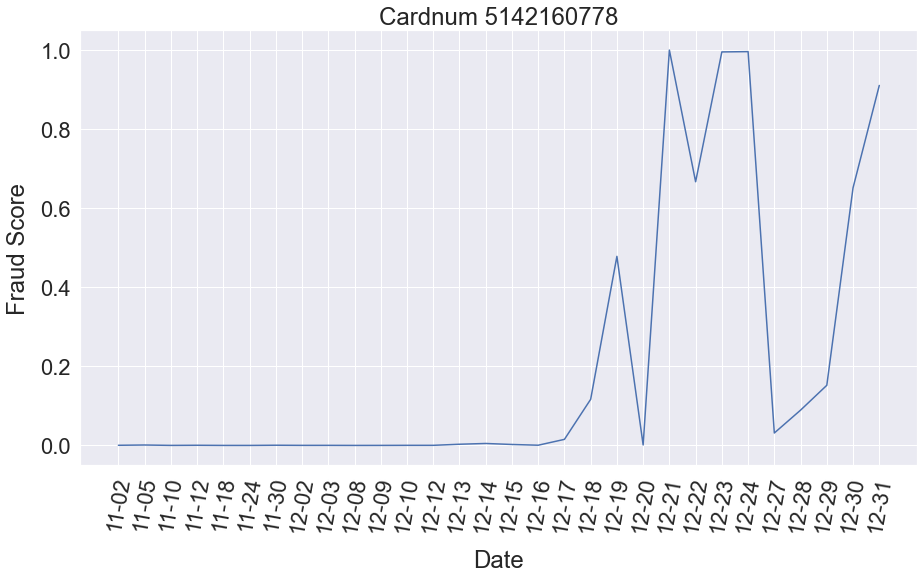

In [279]:
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['font.size'] = 22
fig = plt.figure()
ax = plt.axes()

plt.plot(Cardnumgraph.index, Cardnumgraph['predicted'])
#months = mdates.MonthLocator()  # every month
#ax.xaxis.set_major_locator(months)
plt.xticks(rotation='80')
plt.xlabel('Date', labelpad=15)
plt.ylabel('Fraud Score', labelpad=10)
plt.title("Cardnum 5142160778")

In [280]:
countcardnumgraph=Cardnumgraph[Cardnumgraph.index>='12-16']

In [281]:
countcardnumgraph['Cardnum'].cumsum()

Date
12-16     1
12-17     6
12-18     7
12-19    11
12-20    12
12-21    18
12-22    21
12-23    23
12-24    24
12-27    25
12-28    29
12-29    30
12-30    32
12-31    34
Name: Cardnum, dtype: int64

In [282]:
Cardnumgraph[Cardnumgraph.index>='12-17']

Cardnum  predicted
Date                     
12-17        5   0.015319
12-18        1   0.116560
12-19        4   0.478042
12-20        1   0.001232
12-21        6   0.999562
12-22        3   0.666664
12-23        2   0.994887
12-24        1   0.995648
12-27        1   0.031451
12-28        4   0.089236
12-29        1   0.152045
12-30        2   0.651301
12-31        2   0.910109

In [283]:
Cardnumgraph

Cardnum  predicted
Date                     
11-02        1   0.000384
11-05        1   0.001086
11-10        1   0.000094
11-12        1   0.000435
11-18        1   0.000058
11-24        2   0.000037
11-30        1   0.000523
12-02        2   0.000185
12-03        1   0.000224
12-08        1   0.000051
12-09        1   0.000107
12-10        1   0.000275
12-12        1   0.000269
12-13        2   0.003018
12-14        2   0.004954
12-15        1   0.002435
12-16        1   0.000557
12-17        5   0.015319
12-18        1   0.116560
12-19        4   0.478042
12-20        1   0.001232
12-21        6   0.999562
12-22        3   0.666664
12-23        2   0.994887
12-24        1   0.995648
12-27        1   0.031451
12-28        4   0.089236
12-29        1   0.152045
12-30        2   0.651301
12-31        2   0.910109

Text(0, 0.5, 'Fraud Score')

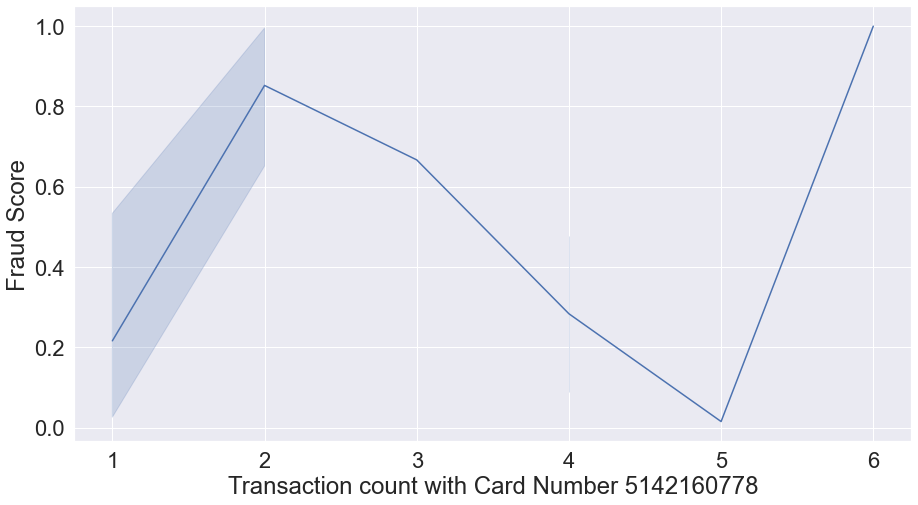

In [284]:
sns.lineplot(x='Cardnum',y='predicted',data=countcardnumgraph)
plt.xlabel('Transaction count with Card Number 5142160778')
plt.ylabel('Fraud Score')